In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime as dt
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
import requests
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Coinbase Utility Functions

In [5]:
def get_coinbase_historical_price_data(
    client,
    ticker,
    start_timestamp,
    end_timestamp,
    granularity="ONE_DAY",
    retries=3,
    delay=5,
):
    """
    Generic candle puller for Coinbase Advanced Trade RESTClient.get_candles().

    granularity examples:
      ONE_MINUTE, FIVE_MINUTE, FIFTEEN_MINUTE, THIRTY_MINUTE,
      ONE_HOUR, TWO_HOUR, FOUR_HOUR, SIX_HOUR, ONE_DAY
    """
    attempts = 0
    while attempts < retries:
        try:
            candle_list = client.get_candles(
                product_id=ticker,
                start=int(start_timestamp),
                end=int(end_timestamp),
                granularity=granularity,
            ).candles

            if not candle_list:
                cols = ["open", "high", "low", "close", "volume"]
                return pd.DataFrame(columns=cols).rename_axis("date")

            candle_data = []
            for c in candle_list:
                candle_data.append(
                    {
                        "date": c["start"],  # epoch seconds
                        "low": float(c["low"]),
                        "high": float(c["high"]),
                        "open": float(c["open"]),
                        "close": float(c["close"]),
                        "volume": float(c["volume"]),
                    }
                )

            df = pd.DataFrame(candle_data)
            if df.empty or "date" not in df.columns:
                cols = ["open", "high", "low", "close", "volume"]
                return pd.DataFrame(columns=cols).rename_axis("date")

            # epoch seconds -> tz-aware UTC -> drop tz (tz-naive UTC)
            s = pd.to_datetime(pd.to_numeric(df["date"], errors="coerce"), unit="s", utc=True).dt.tz_localize(None)

            # Only normalize for daily bars; keep intraday timestamps intact
            if granularity == "ONE_DAY":
                s = s.dt.normalize()

            df["date"] = s
            df = df.set_index("date").sort_index().rename_axis("date")

            return df

        except requests.exceptions.ConnectionError as e:
            print(f"Connection error: {e}. Retrying in {delay} seconds...")
            attempts += 1
            time.sleep(delay)

    raise Exception("Max retries exceeded. Could not connect to Coinbase API.")


In [6]:
def save_historical_crypto_prices_from_coinbase(
    ticker,
    user_start_date=False,
    start_date=None,
    end_date=None,
    save_to_file=False,
    portfolio_name="Default",
    granularity="ONE_DAY",
):
    """
    Pull historical candles for a single ticker at the requested granularity.

    Note: Coinbase candle endpoints have request caps (commonly 300 candles per call),
    so we chunk requests.
    """
    client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)

    if user_start_date:
        start_date = pd.Timestamp(start_date)
    else:
        start_date = cn.coinbase_start_date_by_ticker_dict.get(ticker)
        start_date = pd.Timestamp(start_date)
        if start_date is None:
            print(f"Start date for {ticker} is not included in the dictionary!")
            return None

    end_date = pd.Timestamp(end_date)

    # seconds per bar (used to step chunks without gaps)
    granularity_to_seconds = {
        "ONE_MINUTE": 60,
        "FIVE_MINUTE": 300,
        "FIFTEEN_MINUTE": 900,
        "THIRTY_MINUTE": 1800,
        "ONE_HOUR": 3600,
        "TWO_HOUR": 7200,
        "FOUR_HOUR": 14400,
        "SIX_HOUR": 21600,
        "ONE_DAY": 86400,
    }
    bar_sec = granularity_to_seconds.get(granularity)
    if bar_sec is None:
        raise ValueError(f"Unsupported granularity: {granularity}")

    # Keep your old 6-week chunking (works great for ONE_DAY and FOUR_HOUR),
    # but ensure we never step by +1 day when doing intraday.
    temp_start = start_date
    current_end = temp_start

    dfs = []
    while current_end < end_date:
        # 6 weeks is safe for FOUR_HOUR (≈252 candles) under the typical 300 limit :contentReference[oaicite:1]{index=1}
        current_end = pd.to_datetime(temp_start) + dt.timedelta(weeks=6)
        if current_end > end_date:
            current_end = end_date

        start_ts = int(pd.Timestamp(temp_start).timestamp())
        end_ts = int(pd.Timestamp(current_end).timestamp())

        df_chunk = get_coinbase_historical_price_data(
            client=client,
            ticker=ticker,
            start_timestamp=start_ts,
            end_timestamp=end_ts,
            granularity=granularity,
        )
        dfs.append(df_chunk)

        # advance by exactly one bar to avoid duplicates and avoid gaps
        temp_start = pd.to_datetime(current_end) + pd.Timedelta(seconds=bar_sec)

    if not dfs:
        cols = ["open", "high", "low", "close", "volume"]
        return pd.DataFrame(columns=cols).rename_axis("date")

    df = pd.concat(dfs, axis=0)
    df = df[~df.index.duplicated(keep="last")].sort_index()

    # optional: save_to_file logic can stay as you had it (not shown in your snippet)

    return df


In [7]:
cn_ticker_list = cn.coinbase_start_date_by_ticker_dict

In [8]:
cn_ticker_list

{'BTC-USD': '2016-01-01',
 'ETH-USD': '2016-06-01',
 'SOL-USD': '2021-06-01',
 'ADA-USD': '2021-03-01',
 'AVAX-USD': '2021-09-01',
 'DOT-USD': '2021-06-01',
 'ATOM-USD': '2020-01-01',
 'LTC-USD': '2016-09-01',
 'XRP-USD': '2023-06-01',
 'ALGO-USD': '2019-08-01',
 'XLM-USD': '2019-02-01',
 'TON-USD': '2025-11-18',
 'NEAR-USD': '2022-09-01',
 'ICP-USD': '2021-05-10',
 'HBAR-USD': '2022-10-13',
 'SUI-USD': '2023-05-18',
 'CRO-USD': '2021-11-01',
 'APT-USD': '2022-10-19',
 'XTZ-USD': '2019-08-06',
 'EGLD-USD': '2022-12-07',
 'FIL-USD': '2020-12-09',
 'SEI-USD': '2023-08-15',
 'TIA-USD': '2023-11-01',
 'KAVA-USD': '2023-01-19',
 'ROSE-USD': '2022-04-26',
 'MATIC-USD': '2021-02-01',
 'SKL-USD': '2021-02-01',
 'OP-USD': '2022-06-01',
 'ARB-USD': '2023-03-23',
 'POL-USD': '2024-09-04',
 'IMX-USD': '2021-12-09',
 'STRK-USD': '2024-02-21',
 'BLAST-USD': '2024-06-26',
 'ZK-USD': '2024-09-25',
 'LRC-USD': '2020-09-15',
 'ZORA-USD': '2025-04-24',
 'METIS-USD': '2022-06-28',
 'STX-USD': '2022-01-20'

In [9]:
ticker_list = []
exclude_list = ['USDT-USD','DAI-USD','USD1-USD','PAX-USD','MATIC-USD']
for ticker, date in cn_ticker_list.items():
    if (pd.Timestamp(cn_ticker_list[ticker]).date() <= pd.Timestamp('2022-04-01').date()) & (ticker not in exclude_list):
        ticker_list.append(ticker)

In [10]:
print(len(ticker_list))
ticker_list

40


['BTC-USD',
 'ETH-USD',
 'SOL-USD',
 'ADA-USD',
 'AVAX-USD',
 'DOT-USD',
 'ATOM-USD',
 'LTC-USD',
 'ALGO-USD',
 'XLM-USD',
 'ICP-USD',
 'CRO-USD',
 'XTZ-USD',
 'FIL-USD',
 'SKL-USD',
 'IMX-USD',
 'LRC-USD',
 'STX-USD',
 'DOGE-USD',
 'SHIB-USD',
 'LINK-USD',
 'FET-USD',
 'GRT-USD',
 'RNDR-USD',
 'OXT-USD',
 'AIOZ-USD',
 'DIA-USD',
 'KRL-USD',
 'UNI-USD',
 'AAVE-USD',
 'AMP-USD',
 'COMP-USD',
 'MKR-USD',
 'SNX-USD',
 'SUSHI-USD',
 'CRV-USD',
 'BAL-USD',
 '1INCH-USD',
 'MANA-USD',
 'REQ-USD']

In [20]:
def get_coinbase_price_data_for_ticker_list(start_date, end_date, ticker_list, fill_missing=True):

    df_dict_by_ticker = {}
    ticker_list_len = len(ticker_list)
    loop_start = 0
    loop_end = 0
    counter = 0
    while counter < ticker_list_len:
        loop_start = counter
        if counter == 40:
            loop_end = ticker_list_len
        else:
            loop_end = counter + 10
        print(counter, loop_start, loop_end, ticker_list[loop_start: loop_end])
        for t in ticker_list[loop_start: loop_end]:
            df_dict_by_ticker[t] = save_historical_crypto_prices_from_coinbase(
                ticker=t,
                user_start_date=True,
                start_date=start_date,
                end_date=end_date,
                portfolio_name="Default",
                granularity="FOUR_HOUR",
            )
        counter += 10
    
    # Optional: one combined frame (MultiIndex: ticker, date)
    df_all = pd.concat(df_dict_by_ticker, names=["ticker", "date"]).sort_index()

    # --- build expected 4H grid ---
    start = pd.Timestamp(start_date).floor("4H")
    end = pd.Timestamp(end_date).ceil("4H")
    expected_dates = pd.date_range(start=start, end=end, freq="4H")#, inclusive="left")

    full_index = pd.MultiIndex.from_product(
        [ticker_list, expected_dates],
        names=["ticker", "date"]
    )

    # --- align everything to full grid ---
    df_all = df_all.reindex(full_index)

    # --- flag missing bars ---
    df_all["imputed"] = df_all["close"].isna()

    if fill_missing:
        # Forward-fill ONLY close per ticker (for alignment / valuation)
        df_all["close"] = df_all.groupby(level=0)["close"].ffill()

        # For imputed rows: set OHLC = close, volume=0
        m = df_all["imputed"]
        for col in ["open", "high", "low"]:
            df_all.loc[m, col] = df_all.loc[m, "close"]
        df_all.loc[m, "volume"] = 0.0

    # if you want a flat frame:
    df_all = df_all.reset_index()

    return df_all

In [22]:
%%time
start_date = "2022-04-01"
end_date   = "2024-12-31"
# df_ticker_price_impute = get_coinbase_price_data_for_ticker_list(start_date, end_date, ticker_list, fill_missing=True)

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 8.11 μs


In [ ]:
## Save Files to Parquet for later use
df_ticker_price_impute.to_parquet(
    f"/Users/adheerchauhan/git/trend_following/data_folder/coinbase_4_min_bar_data/coinbase_ohlcv_4min_{start_date}-{end_date}.parquet",
    index=False,
    compression="zstd",  # great balance of size + speed
)

In [24]:
## Read Parquet Files
df_ticker_price_impute = pd.read_parquet(f"/Users/adheerchauhan/git/trend_following/data_folder/coinbase_4_min_bar_data/coinbase_ohlcv_4min_{start_date}-{end_date}.parquet")

In [25]:
df_ticker_price_impute.head()

,ticker,date,low,high,open,close,volume,imputed
0,BTC-USD,2022-04-01 00:00:00,44232.86,45655.42,45525.25,44614.99,4498.191859,False
1,BTC-USD,2022-04-01 04:00:00,44554.06,45115.70,44612.73,45030.70,1866.920775,False
2,BTC-USD,2022-04-01 08:00:00,45009.73,45338.35,45030.71,45082.74,1735.690901,False
3,BTC-USD,2022-04-01 12:00:00,44722.00,46739.24,45081.52,46545.39,5000.839037,False
4,BTC-USD,2022-04-01 16:00:00,45906.00,46607.89,46545.31,46390.69,3498.550271,False


In [26]:
df_ticker_price_impute.shape

(241240, 8)

In [30]:
df_ticker_price_impute.groupby(['ticker']).size()

ticker
1INCH-USD    6031
AAVE-USD     6031
ADA-USD      6031
AIOZ-USD     6031
ALGO-USD     6031
AMP-USD      6031
ATOM-USD     6031
AVAX-USD     6031
BAL-USD      6031
BTC-USD      6031
COMP-USD     6031
CRO-USD      6031
CRV-USD      6031
DIA-USD      6031
DOGE-USD     6031
DOT-USD      6031
ETH-USD      6031
FET-USD      6031
FIL-USD      6031
GRT-USD      6031
ICP-USD      6031
IMX-USD      6031
KRL-USD      6031
LINK-USD     6031
LRC-USD      6031
LTC-USD      6031
MANA-USD     6031
MKR-USD      6031
OXT-USD      6031
REQ-USD      6031
RNDR-USD     6031
SHIB-USD     6031
SKL-USD      6031
SNX-USD      6031
SOL-USD      6031
STX-USD      6031
SUSHI-USD    6031
UNI-USD      6031
XLM-USD      6031
XTZ-USD      6031
dtype: int64

## Backtesting Engine

In [33]:
def estimate_fee_per_trade_w_enable_switch(passive_trade_rate=0.5, maker_fee=0.006, taker_fee=0.012, enable_fees=True):
    if not enable_fees:
        return 0.0
    proportion_maker = passive_trade_rate
    proportion_taker = (1 - passive_trade_rate)
    return (maker_fee * proportion_maker) + (taker_fee * proportion_taker)

In [35]:
# -----------------------------
# NEW: Turnover helpers
# -----------------------------
TURNOVER_COLS = [
    "buy_notional_gross",
    "sell_notional_gross",
    "gross_traded_notional",
    "turnover_pct",
    "turnover_pct_half",
    "buy_turnover_pct",
    "sell_turnover_pct",
]

def ensure_turnover_cols_in_df(df_portfolio: pd.DataFrame) -> pd.DataFrame:
    for c in TURNOVER_COLS:
        if c not in df_portfolio.columns:
            df_portfolio[c] = 0.0
            
    return df_portfolio

def reset_turnover_for_period(df_portfolio: pd.DataFrame, period) -> pd.DataFrame:
    for c in TURNOVER_COLS:
        df_portfolio.loc[period, c] = 0.0

    return df_portfolio

def finalize_turnover_metrics(df_portfolio: pd.DataFrame, period) -> pd.DataFrame:
    pv = float(df_portfolio.loc[period, "total_portfolio_value"])
    gross = float(df_portfolio.loc[period, "gross_traded_notional"])
    buys = float(df_portfolio.loc[period, "buy_notional_gross"])
    sells = float(df_portfolio.loc[period, "sell_notional_gross"])

    if pv > 0:
        df_portfolio.loc[period, "turnover_pct"] = gross / pv
        df_portfolio.loc[period, "turnover_pct_half"] = gross / (2.0 * pv)
        df_portfolio.loc[period, "buy_turnover_pct"] = buys / pv
        df_portfolio.loc[period, "sell_turnover_pct"] = sells / pv
    else:
        df_portfolio.loc[period, "turnover_pct"] = 0.0
        df_portfolio.loc[period, "turnover_pct_half"] = 0.0
        df_portfolio.loc[period, "buy_turnover_pct"] = 0.0
        df_portfolio.loc[period, "sell_turnover_pct"] = 0.0

    return df_portfolio

In [37]:
def roll_portfolio_positions(df_portfolio: pd.DataFrame, current_period) -> pd.DataFrame:
    current_period = pd.Timestamp(current_period)

    cols = [
        "total_position_notional",
        "available_cash",
        "total_portfolio_value",
        "total_portfolio_value_upper_limit",
    ]

    last_vals = df_portfolio.iloc[-1][cols]

    # Ensure the row exists, then assign all columns at once
    if current_period not in df_portfolio.index:
        df_portfolio.loc[current_period, cols] = pd.NA

    df_portfolio.loc[current_period, cols] = last_vals.values

    ## Reset Turnover for New Period
    reset_turnover_for_period(df_portfolio, period=current_period)
    
    return df_portfolio

In [39]:
def compute_deployable_cash(df_portfolio, period, cash_buffer_percentage):

    ## Total Portfolio Value
    pv = float(df_portfolio.loc[period, "total_portfolio_value"])

    ## Cash Buffer to keep prior to taking positions
    desired_cash = pv * cash_buffer_percentage

    ## Available Cash to be deployed for new positions
    avail_cash = float(df_portfolio.loc[period, "available_cash"])
    deployable_cash = max(0.0, avail_cash - desired_cash)
    
    return deployable_cash


def compute_gross_to_deploy_target_per_vintage(df_portfolio, period, cash_buffer_percentage, fwd_return_period):
    """
    NEW: deploy ~1/fwd_return_period of the *target invested* notional each bar (subject to buffer + available cash).

    target_total_invested = PV * (1 - buffer)
    target_per_vintage    = target_total_invested / fwd_return_period

    max_deploy_now        = max(0, available_cash - PV*buffer)
    gross_to_deploy       = min(target_per_vintage, max_deploy_now)
    """
    ## Total Portfolio Value
    pv = float(df_portfolio.loc[period, "total_portfolio_value"])

    ## Available Cash
    avail_cash = float(df_portfolio.loc[period, "available_cash"])

    ## Cash Buffer to keep prior to taking positions
    desired_cash = pv * cash_buffer_percentage
    deployable_cash = max(0.0, avail_cash - desired_cash)

    ## Target Invested per Vintage
    target_total_invested = pv * (1.0 - cash_buffer_percentage)
    target_per_vintage = target_total_invested / float(fwd_return_period)
    gross_to_deploy = min(target_per_vintage, deployable_cash)
    
    return float(gross_to_deploy)


def open_new_vintage_positions(
    df_position, df_portfolio, df_signal, period,
    fwd_return_period, cash_buffer_percentage,
    transaction_cost_est, passive_trade_rate, enable_fees,
    vintage_name, signal_col='trade_signal_exec'
):
    
    df_signal_working = df_signal.copy()
    signal_current_period_cond = (df_signal_working["date"] == period)

    ## Get Estimated T-Cost
    # est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    est_fees = (transaction_cost_est + estimate_fee_per_trade_w_enable_switch(passive_trade_rate=passive_trade_rate, enable_fees=enable_fees))

    ## Calculate cash budget available to be deployed for new positions
    deployable_cash = compute_deployable_cash(df_portfolio, period, cash_buffer_percentage)
    gross_to_deploy = compute_gross_to_deploy_target_per_vintage(
        df_portfolio=df_portfolio,
        period=period,
        cash_buffer_percentage=cash_buffer_percentage,
        fwd_return_period=fwd_return_period,
    )

    ## Get the updated signal for current period
    non_zero_position_cond = (df_signal_working[signal_col].fillna(0).astype(float) != 0.0)
    picks = df_signal_working.loc[signal_current_period_cond & non_zero_position_cond].copy()
    n = len(picks)
    if n == 0 or gross_to_deploy <= 0:
        return df_position, df_portfolio

    ## Update Trade Weights for current period
    # NOTE: it's now informational only; sizing uses gross_to_deploy / n below.
    picks["position_weight"] = 1.0 / (fwd_return_period * n)

    # -----------------------------
    # CHANGE #3: allocate target-per-vintage gross equally across selected names
    # -----------------------------
    picks["trade_notional_gross"] = gross_to_deploy / float(n)

    picks["position_notional"] = picks["trade_notional_gross"] * (1 - est_fees)
    picks["position_size"] = picks["position_notional"] / picks["open"]
    picks["vintage_id"] = vintage_name
    picks["holding_period_counter"] = 1.0

    ## Append the Current Period Signal Dataframe for the Vintage to the Daily Positions Dataframe
    df_position = pd.concat([df_position, picks], ignore_index=True)

    ## Update Portfolio Cash based on new positions
    cash_usage = float(picks["trade_notional_gross"].sum())
    df_portfolio.loc[period, "available_cash"] = float(df_portfolio.loc[period, "available_cash"]) - cash_usage

    # NEW: turnover accounting (buys)
    df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
    df_portfolio.loc[period, "buy_notional_gross"] = float(df_portfolio.loc[period, "buy_notional_gross"]) + cash_usage
    df_portfolio.loc[period, "gross_traded_notional"] = float(df_portfolio.loc[period, "gross_traded_notional"]) + cash_usage

    ## Update Portfolio Positions by Net Notional
    df_portfolio.loc[period, "total_position_notional"] = float(df_portfolio.loc[period, "total_position_notional"]) + float(picks["position_notional"].sum())
    df_portfolio.loc[period, "total_portfolio_value"] = float(df_portfolio.loc[period, "available_cash"]) + float(df_portfolio.loc[period, "total_position_notional"])
    df_portfolio.loc[period, "total_portfolio_value_upper_limit"] = float(df_portfolio.loc[period, "total_portfolio_value"]) * (1 - cash_buffer_percentage)

    return df_position, df_portfolio

def open_new_vintage_positions_with_turnover_cap(
    df_position, df_portfolio, df_signal, period,
    fwd_return_period, cash_buffer_percentage,
    transaction_cost_est, passive_trade_rate, enable_fees,
    vintage_name, signal_col='trade_signal_exec',
    # ---------------- NEW controls ----------------
    held_tickers=None,                 # set[str]: tickers already held (across ALL vintages)
    cooldown_tickers=None,             # set[str]: tickers blocked from re-entry
    max_names=None,                    # int: cap number of names to open this bar
    max_name_weight=0.05,              # float: max gross per name as % of PV
    min_trade_notional_gross=0.0,      # float: skip tiny trades
    regime_filter_cols=None,           # list[str]: boolean columns that must be True/1 (e.g., ["btc_regime_ok","coin_trend_ok"])
    sort_col=None,                     # str: sort key for picks (e.g., "resid_btc_zscore_prev_4h")
    sort_ascending=True,               # True => most negative first (mean reversion long)
):
    df_signal_working = df_signal.copy()
    signal_current_period_cond = (df_signal_working["date"] == period)

    est_fees = (
        transaction_cost_est
        + estimate_fee_per_trade_w_enable_switch(
            passive_trade_rate=passive_trade_rate,
            enable_fees=enable_fees
        )
    )

    gross_to_deploy = compute_gross_to_deploy_target_per_vintage(
        df_portfolio=df_portfolio,
        period=period,
        cash_buffer_percentage=cash_buffer_percentage,
        fwd_return_period=fwd_return_period,
    )
    if gross_to_deploy <= 0:
        return df_position, df_portfolio

    non_zero_position_cond = (df_signal_working[signal_col].fillna(0).astype(float) != 0.0)
    picks = df_signal_working.loc[signal_current_period_cond & non_zero_position_cond].copy()
    if picks.empty:
        return df_position, df_portfolio

    # (1) Anti-stacking: do NOT buy tickers already held anywhere
    if held_tickers:
        picks = picks[~picks["ticker"].isin(held_tickers)]

    # (2) Cooldown: do NOT re-enter just-exited tickers
    if cooldown_tickers:
        picks = picks[~picks["ticker"].isin(cooldown_tickers)]

    # (3) Falling-knife / regime filters (columns must be precomputed upstream)
    if regime_filter_cols:
        for c in regime_filter_cols:
            if c in picks.columns:
                picks = picks[picks[c].astype(int) == 1]

    if picks.empty:
        return df_position, df_portfolio

    # Optional: choose the “best” subset to reduce churn
    if sort_col and sort_col in picks.columns:
        picks = picks.sort_values(sort_col, ascending=sort_ascending)

    if max_names is not None:
        picks = picks.head(int(max_names))

    n = len(picks)
    if n == 0:
        return df_position, df_portfolio

    # (4) Concentration cap: cap gross per name as % of PV
    pv = float(df_portfolio.loc[period, "total_portfolio_value"])
    cap_per_name_gross = max(0.0, float(max_name_weight) * pv)

    equal_gross_per_name = gross_to_deploy / float(n)
    gross_per_name = min(equal_gross_per_name, cap_per_name_gross)

    # (5) Skip tiny trades to avoid fee-churn
    if gross_per_name < float(min_trade_notional_gross):
        return df_position, df_portfolio

    picks["position_weight"] = 1.0 / (fwd_return_period * n)  # informational only
    picks["trade_notional_gross"] = gross_per_name

    picks["position_notional"] = picks["trade_notional_gross"] * (1 - est_fees)
    picks["position_size"] = picks["position_notional"] / picks["open"]
    picks["vintage_id"] = vintage_name
    picks["holding_period_counter"] = 1.0

    df_position = pd.concat([df_position, picks], ignore_index=True)

    cash_usage = float(picks["trade_notional_gross"].sum())
    df_portfolio.loc[period, "available_cash"] = float(df_portfolio.loc[period, "available_cash"]) - cash_usage

    df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
    df_portfolio.loc[period, "buy_notional_gross"] = float(df_portfolio.loc[period, "buy_notional_gross"]) + cash_usage
    df_portfolio.loc[period, "gross_traded_notional"] = float(df_portfolio.loc[period, "gross_traded_notional"]) + cash_usage

    df_portfolio.loc[period, "total_position_notional"] = float(df_portfolio.loc[period, "total_position_notional"]) + float(picks["position_notional"].sum())
    df_portfolio.loc[period, "total_portfolio_value"] = float(df_portfolio.loc[period, "available_cash"]) + float(df_portfolio.loc[period, "total_position_notional"])
    df_portfolio.loc[period, "total_portfolio_value_upper_limit"] = float(df_portfolio.loc[period, "total_portfolio_value"]) * (1 - cash_buffer_percentage)

    return df_position, df_portfolio


In [41]:
def update_open_vintage_positions(df_position, df_portfolio, df_signal, current_period, prior_period, cash_buffer_percentage, vintage_name):
    """
    Roll/mark-to-market positions that were open in `vintage_name` from prior_period to current_period.

    Fixes vs your original:
    - Maps prior positions by (date, vintage_id, ticker) so you never accidentally pull from another vintage.
    - Avoids per-ticker loops; uses merge/map which is faster + safer.
    - Updates holding counter robustly (max across vintage rows) instead of values[0] from an arbitrary row.
    - Updates portfolio total_position_notional by the *delta* in this vintage's mark-to-market.
    - Leaves cash unchanged (correct for MTM-only step).
    """

    current_period = pd.Timestamp(current_period)
    prior_period = pd.Timestamp(prior_period)

    ## Get Vintage Position Data for Prior Period
    notional_cond = (df_position['position_notional'] > 0)
    prior_vintage = df_position.loc[
        (df_position["date"] == prior_period) & (df_position["vintage_id"] == vintage_name) & (notional_cond)
    ].copy()

    ## If there is no Vintage data from the prior period, exit as there is nothing to update.
    if prior_vintage.empty:
        return df_position, df_portfolio

    ## Keep only one row per ticker (should already be one; this guards against accidental duplicates)
    prior_vintage = (
        prior_vintage.sort_values(["ticker"])
        .drop_duplicates(subset=["ticker"], keep="last")
    )

    prior_tickers = prior_vintage["ticker"].tolist()

    ## Get current period rows from signal dataframe for Vintage tickers
    cur_rows = df_signal.loc[
        (df_signal["date"] == current_period) & (df_signal["ticker"].isin(prior_tickers))
    ].copy()

    ## If for some reason df_signal is missing current_period rows for some tickers, drop them.
    if cur_rows.empty:
        return df_position, df_portfolio

    ## Create a map of the Position Size and Weight by ticker from the prior period
    prior_map = prior_vintage.set_index("ticker")[["position_size", "position_weight"]]

    ## Map the Weight and Position Size from the Prior Period to the Current Period
    cur_rows["position_size"] = cur_rows["ticker"].map(prior_map["position_size"])
    cur_rows["position_weight"] = cur_rows["ticker"].map(prior_map["position_weight"])

    ## Drop any tickers we failed to map (should not happen unless data is inconsistent)
    cur_rows = cur_rows.dropna(subset=["position_size", "position_weight"])

    ## Mark all positions to the current open
    cur_rows["position_notional"] = cur_rows["position_size"] * cur_rows["open"]
    cur_rows["vintage_id"] = vintage_name

    ## Update the Holding Counter
    prior_counter = prior_vintage["holding_period_counter"].max()
    cur_rows["holding_period_counter"] = prior_counter + 1

    ## Append to positions table
    df_position = pd.concat([df_position, cur_rows], axis=0, ignore_index=True)

    ## Update portfolio MTM for this vintage (cash unchanged)
    prior_vintage_notional = prior_vintage["position_notional"].sum()
    cur_vintage_notional = cur_rows["position_notional"].sum()
    delta_notional = cur_vintage_notional - prior_vintage_notional

    df_portfolio.loc[current_period, "total_position_notional"] = (
        df_portfolio.loc[current_period, "total_position_notional"] + delta_notional
    )
    df_portfolio.loc[current_period, "total_portfolio_value"] = (
        df_portfolio.loc[current_period, "available_cash"]
        + df_portfolio.loc[current_period, "total_position_notional"]
    )
    df_portfolio.loc[current_period, "total_portfolio_value_upper_limit"] = (
        df_portfolio.loc[current_period, "total_portfolio_value"] * (1 - cash_buffer_percentage)
    )

    return df_position, df_portfolio

In [43]:
def exit_open_vintage_positions(df_position, df_portfolio, df_signal, current_period, prior_period, transaction_cost_est, passive_trade_rate, enable_fees, 
                                cash_buffer_percentage, vintage_name):
    """
    Exits (closes) all open positions for a given vintage at the CURRENT_PERIOD open,
    using position sizes from the PRIOR_PERIOD for that same vintage.

    Key fixes vs your version:
      - Avoids modifying a filtered slice (SettingWithCopy) by building a .copy() frame for exits.
      - Uses a ticker->position_size mapping from df_position (scalar per ticker) and merges via .map().
      - Handles duplicates safely (keeps last by date ordering) and empty cases gracefully.
    """

    # Work on copies to avoid side effects
    df_signal_working = df_signal.copy()

    # --- Conditions ---
    position_current_period_cond = (df_position["date"] == current_period)
    position_prior_period_cond = (df_position["date"] == prior_period)
    signal_current_period_cond = (df_signal_working["date"] == current_period)
    vintage_cond = (df_position["vintage_id"] == vintage_name)

    # --- Estimated total fees/slippage model ---
    # est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    est_fees = (transaction_cost_est + estimate_fee_per_trade_w_enable_switch(passive_trade_rate=passive_trade_rate, enable_fees=enable_fees))

    # --- Identify tickers that were open in the prior period for this vintage ---
    prior_vintage_positions = df_position.loc[position_prior_period_cond & vintage_cond, ["ticker", "position_size", "position_notional"]].copy()

    if prior_vintage_positions.empty:
        # Nothing to exit; return unchanged
        return df_position, df_portfolio

    # If df_position can contain multiple rows per ticker for the same date/vintage,
    # keep the last one deterministically.
    prior_vintage_positions = (
        prior_vintage_positions
        .dropna(subset=["ticker"])
        .drop_duplicates(subset=["ticker"], keep="last")
    )

    non_zero_tickers_prior_period = prior_vintage_positions["ticker"].tolist()

    # --- Build exit frame for current period (copy, so we can mutate safely) ---
    mask_exit = signal_current_period_cond & df_signal_working["ticker"].isin(non_zero_tickers_prior_period)
    df_signal_current_period = df_signal_working.loc[mask_exit].copy()

    if df_signal_current_period.empty:
        # No signal rows for these tickers at current_period; cannot mark/exit
        return df_position, df_portfolio

    # --- Map prior position sizes into current period rows ---
    ticker_to_size = prior_vintage_positions.set_index("ticker")["position_size"]
    df_signal_current_period["position_size"] = df_signal_current_period["ticker"].map(ticker_to_size)

    # If any tickers didn't map (shouldn't happen), set them to 0 and ignore in exit
    df_signal_current_period["position_size"] = df_signal_current_period["position_size"].fillna(0.0)

    # --- Compute exit notional net of fees (sell at open) ---
    df_signal_current_period["position_notional"] = (
        df_signal_current_period["position_size"] * df_signal_current_period["open"]
    )

    prior_period_position_notional = float(prior_vintage_positions['position_notional'].sum())
    current_mtm_position_notional = float(df_signal_current_period["position_notional"].sum())
    exit_net_position_notional = float(df_signal_current_period["position_notional"].sum()) * (1 - est_fees)

    # --- Update portfolio accounting ---
    # Ensure portfolio rows exist
    if current_period not in df_portfolio.index:
        raise KeyError(f"current_period {current_period} not found in df_portfolio.index")
    if "total_position_notional" not in df_portfolio.columns or "available_cash" not in df_portfolio.columns:
        raise KeyError("df_portfolio missing required columns: total_position_notional, available_cash")

    ## Capture the Mark to Market from Previous Open to Current Open prior to exiting the position
    df_portfolio.loc[current_period, "total_position_notional"] = (
        df_portfolio.loc[current_period, "total_position_notional"] + (current_mtm_position_notional - prior_period_position_notional)
    )

    ## Capture the Bookeeping related to Exiting the Vintage
    # Hear we sell the current position notional but in the available cash, we capture the notional net of transaction costs
    df_portfolio.loc[current_period, "total_position_notional"] = (
        df_portfolio.loc[current_period, "total_position_notional"] - current_mtm_position_notional
    )
    df_portfolio.loc[current_period, "available_cash"] = (
        df_portfolio.loc[current_period, "available_cash"] + exit_net_position_notional
    )

    ## Capture the Turnover Accounting
    df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
    df_portfolio.loc[current_period, "sell_notional_gross"] = (
        float(df_portfolio.loc[current_period, "sell_notional_gross"]) + current_mtm_position_notional
    )
    df_portfolio.loc[current_period, "gross_traded_notional"] = (
        float(df_portfolio.loc[current_period, "gross_traded_notional"]) + current_mtm_position_notional
    )

    ## Re-calculate the Total Portfolio Value and Upper Limit based on the Updated Portfolio
    df_portfolio.loc[current_period, "total_portfolio_value"] = (
        df_portfolio.loc[current_period, "available_cash"] + df_portfolio.loc[current_period, "total_position_notional"]
    )
    df_portfolio.loc[current_period, "total_portfolio_value_upper_limit"] = (
        df_portfolio.loc[current_period, "total_portfolio_value"] * (1 - cash_buffer_percentage)
    )

    # --- Append "closed" rows to df_position for audit trail ---
    # Set post-exit state fields
    df_signal_current_period["position_notional"] = 0.0
    df_signal_current_period["position_size"] = 0.0
    df_signal_current_period["position_weight"] = 0.0
    df_signal_current_period["vintage_id"] = vintage_name
    df_signal_current_period["holding_period_counter"] = 0

    # If df_position expects certain columns, align them
    for col in df_position.columns:
        if col not in df_signal_current_period.columns:
            df_signal_current_period[col] = np.nan

    df_signal_current_period = df_signal_current_period[df_position.columns]

    df_position_out = pd.concat([df_position, df_signal_current_period], axis=0, ignore_index=True)

    return df_position_out, df_portfolio

In [45]:
def run_mean_reversion_backtest(df_signal, fwd_return_period, initial_capital, cash_buffer_percentage, transaction_cost_est, passive_trade_rate, enable_fees, 
                                signal_col='trade_signal_exec',
                               # ---------------- NEW controls ----------------
                                held_tickers=None,                 # set[str]: tickers already held (across ALL vintages)
                                cooldown_tickers=None,             # set[str]: tickers blocked from re-entry
                                max_names=None,                    # int: cap number of names to open this bar
                                max_name_weight=0.05,              # float: max gross per name as % of PV
                                min_trade_notional_gross=0.0,      # float: skip tiny trades
                                regime_filter_cols=None,           # list[str]: boolean columns that must be True/1 (e.g., ["btc_regime_ok","coin_trend_ok"])
                                sort_col=None,                     # str: sort key for picks (e.g., "resid_btc_zscore_prev_4h")
                                sort_ascending=True,               # True => most negative first (mean reversion long)
                               ):

    ## Get a list of all the periods in the signal dataframe
    period_list = sorted(df_signal.date.unique())

    if len(period_list) < 4:
        raise ValueError("Need at least 4 periods in df_signal to run this backtest.")

    ## Define the position weight per signal
    daily_weight_allocation = 1 / fwd_return_period # (kept for now; not used directly below)

    ## Initialize first positions in the signal dataframe
    df_signal = df_signal.copy()
    df_signal['position_weight'] = 0.0
    df_signal['position_notional'] = 0.0
    df_signal['position_size'] = 0.0
    df_signal['holding_period_counter'] = 0.0
    df_signal['vintage_id'] = np.nan
    
    ## Estimated T-Cost
    # est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    est_fees = (transaction_cost_est + estimate_fee_per_trade_w_enable_switch(passive_trade_rate=passive_trade_rate, enable_fees=enable_fees))
    
    ## Initialized Position and Portfolio Dataframes
    portfolio_columns = [
        'total_position_notional',
        'available_cash',
        'total_portfolio_value',
        'total_portfolio_value_upper_limit',
        'buy_notional_gross',
        'sell_notional_gross',
        'gross_traded_notional',
        'turnover_pct',
        'turnover_pct_half',
        'buy_turnover_pct',
        'sell_turnover_pct'
    ]
    df_portfolio = pd.DataFrame(columns=portfolio_columns)
    df_portfolio.index.name = 'date'
    df_position = pd.DataFrame(columns=df_signal.columns.tolist())

    ## Initialize the Cash and Portfolio Value prior to processing positions
    first_period = period_list[1]
    second_period = period_list[2]
    third_period = period_list[3]
    
    ## Initialize Daily Portfolio Positions prior to processing positions
    df_portfolio.loc[first_period, 'total_position_notional'] = 0.0
    df_portfolio.loc[first_period, 'available_cash'] = float(initial_capital)
    df_portfolio.loc[first_period, 'total_portfolio_value'] = float(initial_capital)
    df_portfolio.loc[first_period, 'total_portfolio_value_upper_limit'] = float(initial_capital) * (1 - cash_buffer_percentage)

    ## Initialize Turnover Columns
    df_portfolio = reset_turnover_for_period(df_portfolio, period=first_period)

    run_counter = 0
    run_counter_check = np.arange(0, len(period_list), 100).tolist()
    for i, current_period in enumerate(period_list[1:1000], start=1):
        if run_counter in run_counter_check:
            print(run_counter)
        prior_period = period_list[i - 1]
    
        ## Filtering Conditions
        signal_current_period_cond = (df_signal.date == current_period)
        df_signal_current_period = df_signal.loc[signal_current_period_cond].copy()
    
        if current_period > first_period:
            df_portfolio = roll_portfolio_positions(df_portfolio, current_period=current_period)
    
        if current_period == first_period:
            ## Open New Positions for Vintage 1
            df_position, df_portfolio = open_new_vintage_positions_with_turnover_cap(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name='Vintage_1', signal_col=signal_col,
                held_tickers=held_tickers,                 # set[str]: tickers already held (across ALL vintages)
                cooldown_tickers=cooldown_tickers,             # set[str]: tickers blocked from re-entry
                max_names=max_names,                    # int: cap number of names to open this bar
                max_name_weight=max_name_weight,              # float: max gross per name as % of PV
                min_trade_notional_gross=min_trade_notional_gross,      # float: skip tiny trades
                regime_filter_cols=regime_filter_cols,                 # list[str]: boolean columns that must be True/1 (e.g., ["btc_regime_ok","coin_trend_ok"])
                sort_col=sort_col,                    # str: sort key for picks (e.g., "resid_btc_zscore_prev_4h")
                sort_ascending=sort_ascending)
    
        elif current_period == second_period:
            ## Update Positions from Vintage 1
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_1')
    
            ## Open New Positions for Vintage 2
            df_position, df_portfolio = open_new_vintage_positions_with_turnover_cap(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name='Vintage_2', signal_col=signal_col,
                held_tickers=held_tickers,                 # set[str]: tickers already held (across ALL vintages)
                cooldown_tickers=cooldown_tickers,             # set[str]: tickers blocked from re-entry
                max_names=max_names,                    # int: cap number of names to open this bar
                max_name_weight=max_name_weight,              # float: max gross per name as % of PV
                min_trade_notional_gross=min_trade_notional_gross,      # float: skip tiny trades
                regime_filter_cols=regime_filter_cols,                 # list[str]: boolean columns that must be True/1 (e.g., ["btc_regime_ok","coin_trend_ok"])
                sort_col=sort_col,                    # str: sort key for picks (e.g., "resid_btc_zscore_prev_4h")
                sort_ascending=sort_ascending)
    
        elif current_period == third_period:
            ## Update Positions from Vintage 1
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_1')
    
            ## Update Positions from Vintage 2
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_2')
    
            ## Open New Positions for Vintage 3
            df_position, df_portfolio = open_new_vintage_positions_with_turnover_cap(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name='Vintage_3', signal_col=signal_col,
                held_tickers=held_tickers,                 # set[str]: tickers already held (across ALL vintages)
                cooldown_tickers=cooldown_tickers,             # set[str]: tickers blocked from re-entry
                max_names=max_names,                    # int: cap number of names to open this bar
                max_name_weight=max_name_weight,              # float: max gross per name as % of PV
                min_trade_notional_gross=min_trade_notional_gross,      # float: skip tiny trades
                regime_filter_cols=regime_filter_cols,                 # list[str]: boolean columns that must be True/1 (e.g., ["btc_regime_ok","coin_trend_ok"])
                sort_col=sort_col,                    # str: sort key for picks (e.g., "resid_btc_zscore_prev_4h")
                sort_ascending=sort_ascending)
    
        else:
            vintage_list = df_position['vintage_id'].unique().tolist()
            for vintage in vintage_list:
                if pd.isna(vintage):
                    continue
                    
                vintage_cond = (df_position['vintage_id'] == vintage)
                ## Get the Holding Period Counter for the Vintage
                prior_vals = df_position.loc[(df_position.date == prior_period) & vintage_cond, 'holding_period_counter']
                if prior_vals.empty:
                    previous_period_holding_counter = 0
                else:
                    previous_period_holding_counter = prior_vals.max()
                    if pd.isna(previous_period_holding_counter):
                        previous_period_holding_counter = 0
                    previous_period_holding_counter = int(previous_period_holding_counter)
                
                if previous_period_holding_counter >= fwd_return_period:
                    ## Exit all open positions in current period
                    df_position, df_portfolio = exit_open_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        current_period=current_period, prior_period=prior_period, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees,
                        cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage)
                    ## Open New Positions for Vintage that just exited
                    df_position, df_portfolio = open_new_vintage_positions_with_turnover_cap(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name=vintage, signal_col=signal_col,
                        held_tickers=held_tickers,                 # set[str]: tickers already held (across ALL vintages)
                        cooldown_tickers=cooldown_tickers,             # set[str]: tickers blocked from re-entry
                        max_names=max_names,                    # int: cap number of names to open this bar
                        max_name_weight=max_name_weight,              # float: max gross per name as % of PV
                        min_trade_notional_gross=min_trade_notional_gross,      # float: skip tiny trades
                        regime_filter_cols=regime_filter_cols,                 # list[str]: boolean columns that must be True/1 (e.g., ["btc_regime_ok","coin_trend_ok"])
                        sort_col=sort_col,                    # str: sort key for picks (e.g., "resid_btc_zscore_prev_4h")
                        sort_ascending=sort_ascending)
                    
                elif 1 <= previous_period_holding_counter <= (fwd_return_period - 1):
                    ## Update Positions from Vintage
                    df_position, df_portfolio = update_open_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage)

                else:# previous_period_holding_counter == 0:
                    ## Open New Positions for Vintage
                    df_position, df_portfolio = open_new_vintage_positions_with_turnover_cap(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name=vintage, signal_col=signal_col,
                        held_tickers=held_tickers,                 # set[str]: tickers already held (across ALL vintages)
                        cooldown_tickers=cooldown_tickers,             # set[str]: tickers blocked from re-entry
                        max_names=max_names,                    # int: cap number of names to open this bar
                        max_name_weight=max_name_weight,              # float: max gross per name as % of PV
                        min_trade_notional_gross=min_trade_notional_gross,      # float: skip tiny trades
                        regime_filter_cols=regime_filter_cols,                 # list[str]: boolean columns that must be True/1 (e.g., ["btc_regime_ok","coin_trend_ok"])
                        sort_col=sort_col,                    # str: sort key for picks (e.g., "resid_btc_zscore_prev_4h")
                        sort_ascending=sort_ascending)
                    
        ## Compute Turnover Ratios once per bar for the updated portfolio
        df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
        df_portfolio = finalize_turnover_metrics(df_portfolio, current_period)
        run_counter += 1

    return df_position, df_portfolio

In [47]:
# -----------------------------
# Helpers for held/cooldown
# -----------------------------
def _active_cooldown_set(cooldown_until: dict, bar_idx: int) -> set:
    # cooldown_until: ticker -> expiry_idx (inclusive)
    return {t for t, exp in cooldown_until.items() if bar_idx <= exp}

def _compute_held_tickers_excl_self(
    df_position: pd.DataFrame,
    current_period,
    prior_period,
    vintage_list: list,
    processed_vintages: set,
    exclude_vintage: str,
) -> set:
    """
    Held tickers = union of:
      - For vintages already processed this bar: use current_period state (position_notional > 0)
      - For vintages not yet processed this bar: use prior_period state (position_notional > 0)
    Excludes the vintage currently being opened (exclude_vintage) so it doesn't block itself.
    """
    held = set()
    if df_position.empty:
        return held

    for v in vintage_list:
        if pd.isna(v) or v == exclude_vintage:
            continue

        vmask = (df_position["vintage_id"] == v)

        if v in processed_vintages:
            rows = df_position.loc[
                vmask
                & (df_position["date"] == current_period)
                & (df_position["position_notional"] > 0),
                "ticker",
            ]
        else:
            rows = df_position.loc[
                vmask
                & (df_position["date"] == prior_period)
                & (df_position["position_notional"] > 0),
                "ticker",
            ]

        if not rows.empty:
            held.update(rows.dropna().unique().tolist())

    return held

In [49]:
def run_mean_reversion_backtest_w_cooldown(
    df_signal, fwd_return_period, initial_capital, cash_buffer_percentage,
    transaction_cost_est, passive_trade_rate, enable_fees,
    signal_col='trade_signal_exec',
    # ---------------- NEW toggles ----------------
    enable_held_filter: bool = False,          # block buying tickers already held elsewhere
    enable_cooldown_filter: bool = False,      # block re-entry after exit
    cooldown_bars: int = 1,                    # number of bars to block after exit (incl. same bar)
    # ---------------- other controls forwarded to open ----------------
    max_names=None,
    max_name_weight=0.05,
    min_trade_notional_gross=0.0,
    regime_filter_cols=None,
    sort_col=None,
    sort_ascending=True,
):
    # -----------------------------
    # Periods
    # -----------------------------
    period_list = sorted(df_signal.date.unique())
    if len(period_list) < 4:
        raise ValueError("Need at least 4 periods in df_signal to run this backtest.")

    df_signal = df_signal.copy()
    df_signal["position_weight"] = 0.0
    df_signal["position_notional"] = 0.0
    df_signal["position_size"] = 0.0
    df_signal["holding_period_counter"] = 0.0
    df_signal["vintage_id"] = np.nan

    # (not used directly here, but keep as you had it)
    est_fees = (
        transaction_cost_est
        + estimate_fee_per_trade_w_enable_switch(
            passive_trade_rate=passive_trade_rate,
            enable_fees=enable_fees
        )
    )

    portfolio_columns = [
        "total_position_notional",
        "available_cash",
        "total_portfolio_value",
        "total_portfolio_value_upper_limit",
        "buy_notional_gross",
        "sell_notional_gross",
        "gross_traded_notional",
        "turnover_pct",
        "turnover_pct_half",
        "buy_turnover_pct",
        "sell_turnover_pct",
    ]
    df_portfolio = pd.DataFrame(columns=portfolio_columns)
    df_portfolio.index.name = "date"
    df_position = pd.DataFrame(columns=df_signal.columns.tolist())

    first_period = period_list[1]
    second_period = period_list[2]
    third_period = period_list[3]

    df_portfolio.loc[first_period, "total_position_notional"] = 0.0
    df_portfolio.loc[first_period, "available_cash"] = float(initial_capital)
    df_portfolio.loc[first_period, "total_portfolio_value"] = float(initial_capital)
    df_portfolio.loc[first_period, "total_portfolio_value_upper_limit"] = float(initial_capital) * (1 - cash_buffer_percentage)
    df_portfolio = reset_turnover_for_period(df_portfolio, period=first_period)

    # cooldown state lives here (ticker -> expiry bar index)
    cooldown_until = {} if enable_cooldown_filter else None

    run_counter = 0
    run_counter_check = np.arange(0, len(period_list), 100).tolist()

    for i, current_period in enumerate(period_list[1:1000], start=1):
        if run_counter in run_counter_check:
            print(run_counter)

        prior_period = period_list[i - 1]

        # Active cooldown tickers for this bar (if enabled)
        active_cooldown = _active_cooldown_set(cooldown_until, i) if enable_cooldown_filter else None

        # Current bar signal slice
        df_signal_current_period = df_signal.loc[df_signal.date == current_period].copy()

        if current_period > first_period:
            df_portfolio = roll_portfolio_positions(df_portfolio, current_period=current_period)

        # We maintain "processed vintages" within this bar so held-filter is correct even mid-bar
        processed_vintages = set()

        # Helper to call open with computed held/cooldown sets
        def _open(vintage_to_open: str):
            nonlocal df_position, df_portfolio, processed_vintages, active_cooldown

            vintage_list = df_position["vintage_id"].dropna().unique().tolist()

            held_set = None
            if enable_held_filter:
                held_set = _compute_held_tickers_excl_self(
                    df_position=df_position,
                    current_period=current_period,
                    prior_period=prior_period,
                    vintage_list=vintage_list,
                    processed_vintages=processed_vintages,
                    exclude_vintage=vintage_to_open,
                )

            cooldown_set = active_cooldown if enable_cooldown_filter else None

            df_position, df_portfolio = open_new_vintage_positions_with_turnover_cap(
                df_position=df_position,
                df_portfolio=df_portfolio,
                df_signal=df_signal_current_period,
                period=current_period,
                fwd_return_period=fwd_return_period,
                cash_buffer_percentage=cash_buffer_percentage,
                transaction_cost_est=transaction_cost_est,
                passive_trade_rate=passive_trade_rate,
                enable_fees=enable_fees,
                vintage_name=vintage_to_open,
                signal_col=signal_col,
                held_tickers=held_set,
                cooldown_tickers=cooldown_set,
                max_names=max_names,
                max_name_weight=max_name_weight,
                min_trade_notional_gross=min_trade_notional_gross,
                regime_filter_cols=regime_filter_cols,
                sort_col=sort_col,
                sort_ascending=sort_ascending,
            )

            processed_vintages.add(vintage_to_open)

        # -----------------------------
        # Warm start (first 3 bars)
        # -----------------------------
        if current_period == first_period:
            _open("Vintage_1")

        elif current_period == second_period:
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period,
                cash_buffer_percentage=cash_buffer_percentage, vintage_name="Vintage_1"
            )
            processed_vintages.add("Vintage_1")
            _open("Vintage_2")

        elif current_period == third_period:
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period,
                cash_buffer_percentage=cash_buffer_percentage, vintage_name="Vintage_1"
            )
            processed_vintages.add("Vintage_1")

            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period,
                cash_buffer_percentage=cash_buffer_percentage, vintage_name="Vintage_2"
            )
            processed_vintages.add("Vintage_2")

            _open("Vintage_3")

        # -----------------------------
        # Main loop
        # -----------------------------
        else:
            vintage_list = df_position["vintage_id"].dropna().unique().tolist()

            for vintage in vintage_list:
                if pd.isna(vintage):
                    continue

                vintage_cond = (df_position["vintage_id"] == vintage)

                prior_vals = df_position.loc[
                    (df_position.date == prior_period) & vintage_cond,
                    "holding_period_counter"
                ]
                if prior_vals.empty:
                    previous_period_holding_counter = 0
                else:
                    previous_period_holding_counter = prior_vals.max()
                    if pd.isna(previous_period_holding_counter):
                        previous_period_holding_counter = 0
                    previous_period_holding_counter = int(previous_period_holding_counter)

                if previous_period_holding_counter >= fwd_return_period:
                    # Determine which tickers are being exited (for cooldown)
                    tickers_to_exit = []
                    if enable_cooldown_filter:
                        tickers_to_exit = df_position.loc[
                            (df_position["date"] == prior_period)
                            & (df_position["vintage_id"] == vintage)
                            & (df_position["position_notional"] > 0),
                            "ticker"
                        ].dropna().unique().tolist()

                    # Exit
                    df_position, df_portfolio = exit_open_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        current_period=current_period, prior_period=prior_period,
                        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                        enable_fees=enable_fees,
                        cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage
                    )
                    processed_vintages.add(vintage)

                    # Start cooldown (blocks same-bar re-entry too)
                    if enable_cooldown_filter and tickers_to_exit:
                        for t in tickers_to_exit:
                            new_exp = i + int(cooldown_bars)
                            cooldown_until[t] = max(cooldown_until.get(t, -1), new_exp)

                        # refresh active set for subsequent opens this same bar
                        active_cooldown = _active_cooldown_set(cooldown_until, i)

                    # Re-open this vintage
                    _open(vintage)

                elif 1 <= previous_period_holding_counter <= (fwd_return_period - 1):
                    df_position, df_portfolio = update_open_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        current_period=current_period, prior_period=prior_period,
                        cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage
                    )
                    processed_vintages.add(vintage)

                else:
                    # Vintage is flat; open if signal present
                    _open(vintage)

        # Turnover metrics
        df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
        df_portfolio = finalize_turnover_metrics(df_portfolio, current_period)
        run_counter += 1

        # Optional: prune expired cooldown entries
        if enable_cooldown_filter and cooldown_until:
            cooldown_until = {t: exp for t, exp in cooldown_until.items() if exp >= i}

    return df_position, df_portfolio


## Signal Construction

In [52]:
def calculate_z_score(df, return_col, date_col, z_score_col_name):

    return_mean = df.groupby([date_col])[return_col].transform('mean')
    return_std = df.groupby([date_col])[return_col].transform('std').replace(0, np.nan)
    df[z_score_col_name] = (df[return_col] - return_mean) / return_std

    return df
    

def build_return_features(df, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50):

    df_returns = df.copy()

    ## Get Previous 4 hour returns
    ticker_group_close = df_returns.groupby(['ticker'])['close']
    df_returns['close_log_return_prev_4h'] = np.log(ticker_group_close.shift(1) / ticker_group_close.shift(2))

    ## Require a minimum number of tickers to calculate Z-Score for a given bar
    ticker_count_by_date = df_returns.groupby(['date'])['ticker'].transform('nunique')
    df_returns = df_returns[ticker_count_by_date >= min_z_score_ticker_count]

    ## Calculate cross-sectional Z-Score across all tickers per bar
    df_returns = calculate_z_score(df_returns, return_col='close_log_return_prev_4h', date_col='date', z_score_col_name='close_log_return_z_score_prev_4h')

    ## Get forward return for specified period (Open(T) to Open(T+H))
    df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = np.log(df_returns.groupby(['ticker'])['open'].shift(-fwd_return_period) / df_returns['open'])

    ## Winsorize Forward Return to reduce data glitches
    if winsorize_fwd_return:
        df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'].clip(-fwd_return_cap, fwd_return_cap)

    return df_returns

In [54]:
## Break the Z-Scores per period into Deciles
def cs_bucket(group, col, q=10):
    # cross-sectional bucketing within each timestamp
    return pd.qcut(group[col], q=q, labels=False, duplicates="drop")

def get_mean_reversion_signal(df_ohlc, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50, bottom_q=0.2):

    df = df_ohlc.copy()
    df_signal = build_return_features(df, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50)
    return_cols = ['close_log_return_prev_4h','fwd_open_log_return_12h']
    df_signal = df_signal.dropna(subset=return_cols).copy()

    df_signal["quantile_bucket"] = df_signal.groupby("date", group_keys=False).apply(
        lambda g: cs_bucket(g, "close_log_return_z_score_prev_4h", q=10)
    )
    
    ## Identify bottom performing tickers per period
    q = bottom_q  # bottom 20%
    df_signal["bottom_quintile_signal"] = df_signal.groupby("date")["close_log_return_z_score_prev_4h"].transform(
        lambda s: s <= s.quantile(q)
    )
    
    # compute signal on bar close, execute next bar open
    df_signal = df_signal.sort_values(["ticker", "date"])
    df_signal["trade_signal"] = df_signal["bottom_quintile_signal"].astype(float)
    df_signal["trade_signal_exec"] = df_signal.groupby("ticker")["trade_signal"].fillna(0.0)

    return df_signal

In [56]:
def add_btc_residual_returns(
    df: pd.DataFrame,
    btc_ticker: str = "BTC-USD",
    date_col: str = "date",
    ticker_col: str = "ticker",
    ret_col: str = "close_log_return_prev_4h",
    lookback_days: int = 30,
    min_obs_days: int = 10,
    bars_per_day: int = 6,
    lag_params: bool = True,
    var_floor: float = 1e-12,
) -> pd.DataFrame:
    """
    Adds rolling BTC-factor residual returns for each ticker:
        resid = r_i - (alpha + beta * r_btc)

    Uses rolling OLS with intercept over lookback window (in bars).
    If lag_params=True, alpha/beta are shifted by 1 bar to avoid lookahead.
    """
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col])
    out = out.sort_values([ticker_col, date_col])

    lookback_bars = int(lookback_days * bars_per_day)
    min_periods = int(min_obs_days * bars_per_day)

    # --- Pull BTC returns by timestamp and merge onto all rows ---
    btc = (
        out.loc[out[ticker_col] == btc_ticker, [date_col, ret_col]]
        .drop_duplicates(subset=[date_col])
        .rename(columns={ret_col: "btc_ret"})
        .sort_values(date_col)
    )

    out = out.merge(btc, on=date_col, how="left")

    # Initialize columns
    out["beta_btc"] = np.nan
    out["alpha_btc"] = np.nan
    out["resid_btc_prev_4h"] = np.nan

    # --- Compute rolling alpha/beta/resid per non-BTC ticker ---
    non_btc_mask = out[ticker_col] != btc_ticker

    def _per_ticker(g: pd.DataFrame) -> pd.DataFrame:
        g = g.sort_values(date_col).copy()
        y = g[ret_col].astype(float)
        x = g["btc_ret"].astype(float)

        # rolling moments
        mx  = x.rolling(lookback_bars, min_periods=min_periods).mean()
        my  = y.rolling(lookback_bars, min_periods=min_periods).mean()
        mxy = (x * y).rolling(lookback_bars, min_periods=min_periods).mean()
        mx2 = (x * x).rolling(lookback_bars, min_periods=min_periods).mean()

        cov_xy = mxy - mx * my
        var_x  = mx2 - mx * mx

        ## OLS Definitions for beta and alpha
        beta = cov_xy / var_x
        beta = beta.where(var_x > var_floor)  # avoid divide-by-zero issues
        alpha = my - beta * mx

        if lag_params:
            beta = beta.shift(1)
            alpha = alpha.shift(1)

        resid = y - (alpha + beta * x)

        g["beta_btc"] = beta
        g["alpha_btc"] = alpha
        g["resid_btc_prev_4h"] = resid
        return g

    out.loc[non_btc_mask] = (
        out.loc[non_btc_mask]
        .groupby(ticker_col, group_keys=False)
        .apply(_per_ticker)
    )

    # BTC itself: not tradable in this sleeve, keep residual NaN
    # (If you prefer explicitly 0, uncomment below.)
    # out.loc[out[ticker_col] == btc_ticker, "resid_btc_prev_4h"] = 0.0

    return out


In [58]:
df_signal = get_mean_reversion_signal(df_ticker_price_impute, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50, bottom_q=0.2)

In [59]:
df_signal.head()

,ticker,date,low,high,open,close,volume,imputed,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket,bottom_quintile_signal,trade_signal,trade_signal_exec
223149,1INCH-USD,2022-04-01 08:00:00,1.738,1.772,1.757,1.747,43729.16,False,0.027146,0.152888,0.068196,7,False,0.0,0.0
223150,1INCH-USD,2022-04-01 12:00:00,1.710,1.831,1.744,1.816,149897.91,False,-0.004569,0.127891,0.074558,6,False,0.0,0.0
223151,1INCH-USD,2022-04-01 16:00:00,1.809,1.885,1.819,1.880,167483.50,False,0.038736,-0.044778,0.058196,5,False,0.0,0.0
223152,1INCH-USD,2022-04-01 20:00:00,1.856,1.890,1.881,1.882,219778.94,False,0.034635,0.904957,0.019479,8,False,0.0,0.0
223153,1INCH-USD,2022-04-02 00:00:00,1.869,1.953,1.879,1.928,228449.80,False,0.001063,0.306189,0.070872,6,False,0.0,0.0


In [62]:
## Signal with orthogonalized to BTC returns
df_signal_btc_residual = build_return_features(
    df_ticker_price_impute,
    min_z_score_ticker_count=20,
    fwd_return_period=3,
    winsorize_fwd_return=True,
    fwd_return_cap=0.50,
)

df_signal_btc_residual = add_btc_residual_returns(
    df_signal_btc_residual,
    btc_ticker="BTC-USD",
    ret_col="close_log_return_prev_4h",
    lookback_days=30,   # 180 bars
    min_obs_days=10,    # 60 bars
    lag_params=True,    # strict no-lookahead
)

# Now build your cross-sectional z-score on resid instead of raw return
df_signal_btc_residual = calculate_z_score(
    df_signal_btc_residual,
    return_col="resid_btc_prev_4h",
    date_col="date",
    z_score_col_name="resid_btc_zscore_prev_4h",
)

## Break the Z-Scores per period into Deciles
def cs_bucket(group, col, q=10):
    # cross-sectional bucketing within each timestamp
    return pd.qcut(group[col], q=q, labels=False, duplicates="drop")

df_signal_btc_residual["quantile_bucket"] = df_signal_btc_residual.groupby("date", group_keys=False).apply(
    lambda g: cs_bucket(g, "resid_btc_zscore_prev_4h", q=10)
)

## Identify bottom performing tickers per period
q = 0.2  # bottom 20%
df_signal_btc_residual["bottom_quintile_signal"] = df_signal_btc_residual.groupby("date")["resid_btc_zscore_prev_4h"].transform(
    lambda s: s <= s.quantile(q)
)

# compute signal on bar close, execute next bar open
df_signal_btc_residual = df_signal_btc_residual.sort_values(["ticker", "date"])
df_signal_btc_residual["trade_signal"] = df_signal_btc_residual["bottom_quintile_signal"].astype(float)
df_signal_btc_residual["trade_signal_exec"] = df_signal_btc_residual.groupby("ticker")["trade_signal"].fillna(0.0)

# then use trade_signal_exec (not trade_signal) in open_new_vintage_positions
df_signal_btc_residual_filt = df_signal_btc_residual[df_signal_btc_residual['resid_btc_zscore_prev_4h'].notnull()].reset_index(drop=True)

In [64]:
## Strategy Params
initial_capital = 1000
cash_buffer_percentage = 0.10
fwd_return_period = 3
transaction_cost_est = 0.001
passive_trade_rate = 0.05
enable_fees = True
# daily_weight_allocation = 1 / fwd_return_period
# period_list = df_signal.date.unique().tolist()
# first_period = period_list[0]

In [66]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost, df_daily_portfolio_with_t_cost = run_mean_reversion_backtest(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                            cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                            passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec')

df_daily_portfolio_with_t_cost['daily_pct_returns'] = df_daily_portfolio_with_t_cost['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.948469824807856,
 'annualized_sharpe_ratio': -8.364784629073064,
 'calmar_ratio': -0.9487457096985279,
 'annualized_std_dev': 0.3516775387197782,
 'max_drawdown': -0.9997092109214812,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.2832832832832833,
 't_statistic': -13.601052630709516,
 'p_value': 8.947597001091062e-39,
 'trade_count': 999.0}

In [67]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost_btc_resid, df_daily_portfolio_with_t_cost_btc_resid = run_mean_reversion_backtest(df_signal_btc_residual_filt, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec')

df_daily_portfolio_with_t_cost_btc_resid['daily_pct_returns'] = df_daily_portfolio_with_t_cost_btc_resid['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_btc_resid['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost_btc_resid, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.9478578547990066,
 'annualized_sharpe_ratio': -8.305594822634953,
 'calmar_ratio': -0.9481520442671846,
 'annualized_std_dev': 0.3527275099203719,
 'max_drawdown': -0.9996917070613222,
 'max_drawdown_duration': Timedelta('166 days 08:00:00'),
 'hit_rate': 0.28428428428428426,
 't_statistic': -13.503888770059437,
 'p_value': 2.7371385730052825e-38,
 'trade_count': 999.0}

In [68]:
df_signal_btc_residual_filt[['close_log_return_z_score_prev_4h','resid_btc_zscore_prev_4h']].corr()

,close_log_return_z_score_prev_4h,resid_btc_zscore_prev_4h
close_log_return_z_score_prev_4h,1.00000,0.97181
resid_btc_zscore_prev_4h,0.97181,1.00000


In [70]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost_held_tickers, df_daily_portfolio_with_t_cost_held_tickers = run_mean_reversion_backtest_w_cooldown(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                                 cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                                 passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec',
                                                                                                                                 # ---------------- NEW toggles ----------------
                                                                                                                                 enable_held_filter = True,          # block buying tickers already held elsewhere
                                                                                                                                 enable_cooldown_filter = False,      # block re-entry after exit
                                                                                                                                 cooldown_bars = 1,                    # number of bars to block after exit (incl. same bar)
                                                                                                                                 # ---------------- other controls forwarded to open ----------------
                                                                                                                                 max_names=None,
                                                                                                                                 max_name_weight=0.05,
                                                                                                                                 min_trade_notional_gross=0.0,
                                                                                                                                 regime_filter_cols=None,
                                                                                                                                 sort_col=None,
                                                                                                                                 sort_ascending=True)

df_daily_portfolio_with_t_cost_held_tickers['daily_pct_returns'] = df_daily_portfolio_with_t_cost_held_tickers['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_held_tickers['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost_held_tickers, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.9297951675496547,
 'annualized_sharpe_ratio': -8.62112527285733,
 'calmar_ratio': -0.9304259097586728,
 'annualized_std_dev': 0.3073224456069981,
 'max_drawdown': -0.9993220930302966,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.2822822822822823,
 't_statistic': -13.991714500663715,
 'p_value': 9.456893194125224e-41,
 'trade_count': 999.0}

In [71]:
df_daily_position_with_t_cost.groupby(['date','ticker']).agg({'vintage_id':'nunique'}).head(200)

vintage_id
date                ticker               
2022-04-01 12:00:00 AAVE-USD            1
                    ADA-USD             1
                    COMP-USD            1
                    DOT-USD             1
                    IMX-USD             1
                    LRC-USD             1
                    SKL-USD             1
                    SOL-USD             1
2022-04-01 16:00:00 AAVE-USD            1
                    ADA-USD             1
                    AMP-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    DOT-USD             1
                    IMX-USD             1
                    KRL-USD             1
                    LRC-USD             1
                    LTC-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    SKL-USD             1
                    SNX-USD             1
                    SOL-USD             1
2022-04-01 20:00:00 AAVE-USD            1
                    ADA-USD             1
                    AIOZ-USD            1
                    ALGO-USD            1
                    AMP-USD             1
                    BAL-USD             1
                    BTC-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    DOT-USD             1
                    IMX-USD             2
                    KRL-USD             1
                    LINK-USD            1
                    LRC-USD             1
                    LTC-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    RNDR-USD            1
                    SKL-USD             2
                    SNX-USD             1
                    SOL-USD             1
2022-04-02 00:00:00 AAVE-USD            1
                    ADA-USD             1
                    AIOZ-USD            1
                    ALGO-USD            1
                    AMP-USD             1
                    AVAX-USD            1
                    BAL-USD             1
                    BTC-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    DOT-USD             1
                    IMX-USD             2
                    KRL-USD             2
                    LINK-USD            1
                    LRC-USD             1
                    LTC-USD             1
                    MKR-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    RNDR-USD            2
                    SKL-USD             2
                    SNX-USD             1
                    SOL-USD             1
                    SUSHI-USD           1
                    UNI-USD             1
2022-04-02 04:00:00 AAVE-USD            1
                    AIOZ-USD            2
                    ALGO-USD            1
                    AMP-USD             1
                    AVAX-USD            1
                    BAL-USD             2
                    BTC-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    IMX-USD             1
                    KRL-USD             2
                    LINK-USD            2
                    LTC-USD             1
                    MKR-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    RNDR-USD            2
                    SKL-USD             2
                    SNX-USD             1
                    SOL-USD             1
                    SUSHI-USD           1

In [72]:
df_daily_position_with_t_cost_held_tickers.groupby(['date','ticker']).agg({'vintage_id':'nunique'}).head(200)

vintage_id
date                ticker               
2022-04-01 12:00:00 AAVE-USD            1
                    ADA-USD             1
                    COMP-USD            1
                    DOT-USD             1
                    IMX-USD             1
                    LRC-USD             1
                    SKL-USD             1
                    SOL-USD             1
2022-04-01 16:00:00 AAVE-USD            1
                    ADA-USD             1
                    AMP-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    DOT-USD             1
                    IMX-USD             1
                    KRL-USD             1
                    LRC-USD             1
                    LTC-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    SKL-USD             1
                    SNX-USD             1
                    SOL-USD             1
2022-04-01 20:00:00 AAVE-USD            1
                    ADA-USD             1
                    AIOZ-USD            1
                    ALGO-USD            1
                    AMP-USD             1
                    BAL-USD             1
                    BTC-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    DOT-USD             1
                    IMX-USD             1
                    KRL-USD             1
                    LINK-USD            1
                    LRC-USD             1
                    LTC-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    RNDR-USD            1
                    SKL-USD             1
                    SNX-USD             1
                    SOL-USD             1
2022-04-02 00:00:00 AAVE-USD            1
                    ADA-USD             1
                    AIOZ-USD            1
                    ALGO-USD            1
                    AMP-USD             1
                    AVAX-USD            1
                    BAL-USD             1
                    BTC-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    DOT-USD             1
                    IMX-USD             1
                    KRL-USD             1
                    LINK-USD            1
                    LRC-USD             1
                    LTC-USD             1
                    MKR-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    RNDR-USD            1
                    SKL-USD             1
                    SNX-USD             1
                    SOL-USD             1
                    SUSHI-USD           1
                    UNI-USD             1
2022-04-02 04:00:00 AAVE-USD            1
                    AIOZ-USD            1
                    ALGO-USD            1
                    AMP-USD             1
                    AVAX-USD            1
                    BAL-USD             1
                    BTC-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    KRL-USD             1
                    LINK-USD            1
                    LTC-USD             1
                    MKR-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    RNDR-USD            1
                    SKL-USD             1
                    SNX-USD             1
                    SOL-USD             1
                    SUSHI-USD           1
                    UNI-USD             1

In [73]:
df_daily_position_with_t_cost_held_tickers.groupby(['date','vintage_id']).agg({'ticker':'nunique'}).head(20)

ticker
date                vintage_id        
2022-04-01 12:00:00 Vintage_1        8
2022-04-01 16:00:00 Vintage_1        8
                    Vintage_2        8
2022-04-01 20:00:00 Vintage_1        8
                    Vintage_2        8
                    Vintage_3        6
2022-04-02 00:00:00 Vintage_1       12
                    Vintage_2        8
                    Vintage_3        6
2022-04-02 04:00:00 Vintage_1        6
                    Vintage_2       10
                    Vintage_3        6
2022-04-02 08:00:00 Vintage_1        6
                    Vintage_2        5
                    Vintage_3       10
2022-04-02 12:00:00 Vintage_1       11
                    Vintage_2        5
                    Vintage_3        5
2022-04-02 16:00:00 Vintage_1        5
                    Vintage_2        9

<Axes: xlabel='date'>

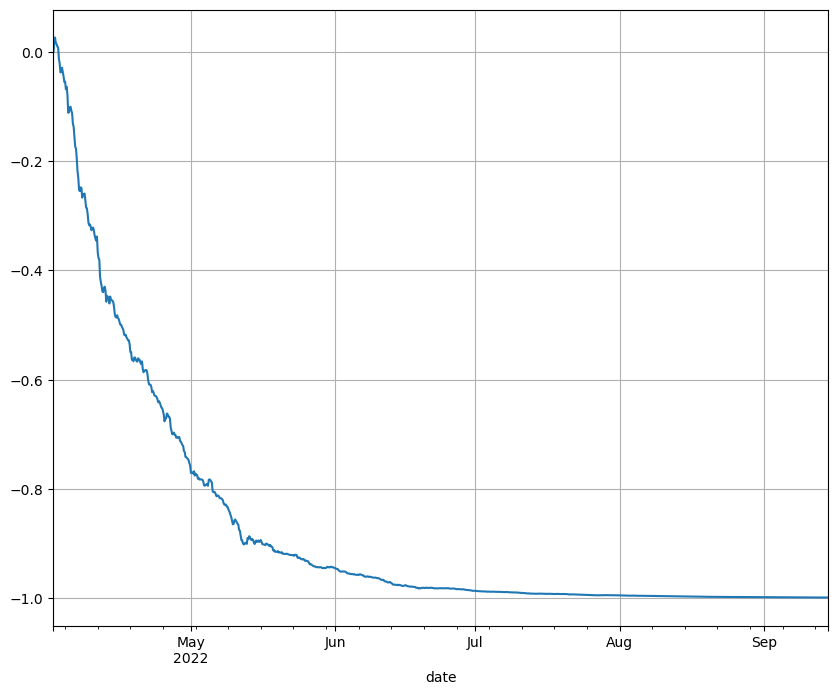

In [74]:
df_daily_portfolio_with_t_cost_held_tickers['strategy_cumulative_return'].plot(figsize=(10,8), grid=True)

In [75]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost_held_tickers_cooldown_1, df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1 = run_mean_reversion_backtest_w_cooldown(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                                                     cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                                                     passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec',
                                                                                                                                                     # ---------------- NEW toggles ----------------
                                                                                                                                                     enable_held_filter = True,          # block buying tickers already held elsewhere
                                                                                                                                                     enable_cooldown_filter = True,      # block re-entry after exit
                                                                                                                                                     cooldown_bars = 1,                    # number of bars to block after exit (incl. same bar)
                                                                                                                                                     # ---------------- other controls forwarded to open ----------------
                                                                                                                                                     max_names=None,
                                                                                                                                                     max_name_weight=0.05,
                                                                                                                                                     min_trade_notional_gross=0.0,
                                                                                                                                                     regime_filter_cols=None,
                                                                                                                                                     sort_col=None,
                                                                                                                                                     sort_ascending=True)

df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1['daily_pct_returns'] = df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.8740184109753152,
 'annualized_sharpe_ratio': -8.235723634981904,
 'calmar_ratio': -0.8769640695335038,
 'annualized_std_dev': 0.2529927159326858,
 'max_drawdown': -0.9966410726955375,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.2862862862862863,
 't_statistic': -13.298272590945372,
 'p_value': 2.8645228902357404e-37,
 'trade_count': 999.0}

In [76]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost_held_tickers_cooldown_3, df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3 = run_mean_reversion_backtest_w_cooldown(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                                                     cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                                                     passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec',
                                                                                                                                                     # ---------------- NEW toggles ----------------
                                                                                                                                                     enable_held_filter = True,          # block buying tickers already held elsewhere
                                                                                                                                                     enable_cooldown_filter = True,      # block re-entry after exit
                                                                                                                                                     cooldown_bars = 3,                    # number of bars to block after exit (incl. same bar)
                                                                                                                                                     # ---------------- other controls forwarded to open ----------------
                                                                                                                                                     max_names=None,
                                                                                                                                                     max_name_weight=0.05,
                                                                                                                                                     min_trade_notional_gross=0.0,
                                                                                                                                                     regime_filter_cols=None,
                                                                                                                                                     sort_col=None,
                                                                                                                                                     sort_ascending=True)

df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3['daily_pct_returns'] = df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.8151155856900743,
 'annualized_sharpe_ratio': -8.204729002568321,
 'calmar_ratio': -0.8230145743741509,
 'annualized_std_dev': 0.20866274325302617,
 'max_drawdown': -0.9904023708327603,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.2902902902902903,
 't_statistic': -13.179328733759478,
 'p_value': 1.1016411578280889e-36,
 'trade_count': 999.0}

In [77]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost_held_tickers_cooldown_5, df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5 = run_mean_reversion_backtest_w_cooldown(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                                                     cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                                                     passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec',
                                                                                                                                                     # ---------------- NEW toggles ----------------
                                                                                                                                                     enable_held_filter = True,          # block buying tickers already held elsewhere
                                                                                                                                                     enable_cooldown_filter = True,      # block re-entry after exit
                                                                                                                                                     cooldown_bars = 5,                    # number of bars to block after exit (incl. same bar)
                                                                                                                                                     # ---------------- other controls forwarded to open ----------------
                                                                                                                                                     max_names=None,
                                                                                                                                                     max_name_weight=0.05,
                                                                                                                                                     min_trade_notional_gross=0.0,
                                                                                                                                                     regime_filter_cols=None,
                                                                                                                                                     sort_col=None,
                                                                                                                                                     sort_ascending=True)

df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5['daily_pct_returns'] = df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.7555114411609621,
 'annualized_sharpe_ratio': -7.805789096162204,
 'calmar_ratio': -0.7714192466772836,
 'annualized_std_dev': 0.18428065089563347,
 'max_drawdown': -0.9793785213619692,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.2992992992992993,
 't_statistic': -12.468700753093984,
 'p_value': 2.8838971226788835e-33,
 'trade_count': 999.0}

In [78]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost_held_tickers_cooldown_10, df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10 = run_mean_reversion_backtest_w_cooldown(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                                                     cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                                                     passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec',
                                                                                                                                                     # ---------------- NEW toggles ----------------
                                                                                                                                                     enable_held_filter = True,          # block buying tickers already held elsewhere
                                                                                                                                                     enable_cooldown_filter = True,      # block re-entry after exit
                                                                                                                                                     cooldown_bars = 10,                    # number of bars to block after exit (incl. same bar)
                                                                                                                                                     # ---------------- other controls forwarded to open ----------------
                                                                                                                                                     max_names=None,
                                                                                                                                                     max_name_weight=0.05,
                                                                                                                                                     min_trade_notional_gross=0.0,
                                                                                                                                                     regime_filter_cols=None,
                                                                                                                                                     sort_col=None,
                                                                                                                                                     sort_ascending=True)

df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10['daily_pct_returns'] = df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.6429821733144083,
 'annualized_sharpe_ratio': -8.052187308329446,
 'calmar_ratio': -0.6826622084068296,
 'annualized_std_dev': 0.13276389879964182,
 'max_drawdown': -0.9418745689980043,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.28428428428428426,
 't_statistic': -12.706256991727667,
 'p_value': 2.149327361178077e-34,
 'trade_count': 999.0}

In [79]:
enable_fees

True

In [80]:
## Backtest with No Transaction Costs of Fees
df_daily_position_with_no_t_cost_held_tickers_cooldown_3, df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3 = run_mean_reversion_backtest_w_cooldown(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                                                     cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                                                     passive_trade_rate=passive_trade_rate, enable_fees=False, signal_col='trade_signal_exec',
                                                                                                                                                     # ---------------- NEW toggles ----------------
                                                                                                                                                     enable_held_filter = True,          # block buying tickers already held elsewhere
                                                                                                                                                     enable_cooldown_filter = True,      # block re-entry after exit
                                                                                                                                                     cooldown_bars = 3,                    # number of bars to block after exit (incl. same bar)
                                                                                                                                                     # ---------------- other controls forwarded to open ----------------
                                                                                                                                                     max_names=None,
                                                                                                                                                     max_name_weight=0.05,
                                                                                                                                                     min_trade_notional_gross=0.0,
                                                                                                                                                     regime_filter_cols=None,
                                                                                                                                                     sort_col=None,
                                                                                                                                                     sort_ascending=True)

df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3['daily_pct_returns'] = df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3['total_portfolio_value'].pct_change()
df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.16285560730183857,
 'annualized_sharpe_ratio': -0.9629250498535125,
 'calmar_ratio': -0.323962614320148,
 'annualized_std_dev': 0.21196406065857515,
 'max_drawdown': -0.5026987686329156,
 'max_drawdown_duration': Timedelta('163 days 20:00:00'),
 'hit_rate': 0.4844844844844845,
 't_statistic': -1.211797367735862,
 'p_value': 0.2258767810422575,
 'trade_count': 999.0}

<Axes: title={'center': 'Cumulative Returns'}, xlabel='date'>

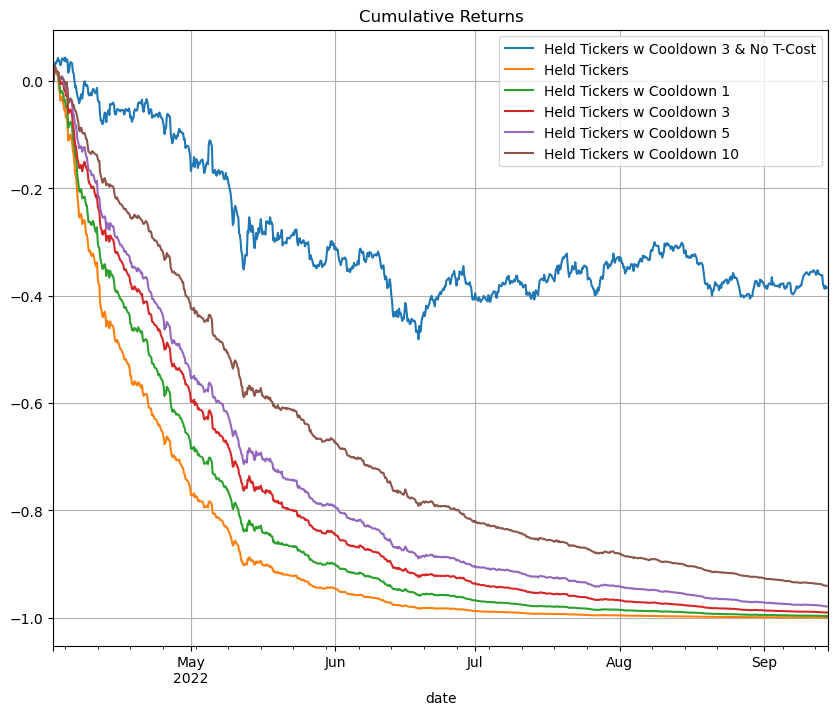

In [81]:
df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 3 & No T-Cost', legend=True)
df_daily_portfolio_with_t_cost_held_tickers['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='Held Tickers', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 1', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 3', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 5', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 10', legend=True, title='Cumulative Returns')

<Axes: title={'center': 'Total Portfolio Value'}, xlabel='date'>

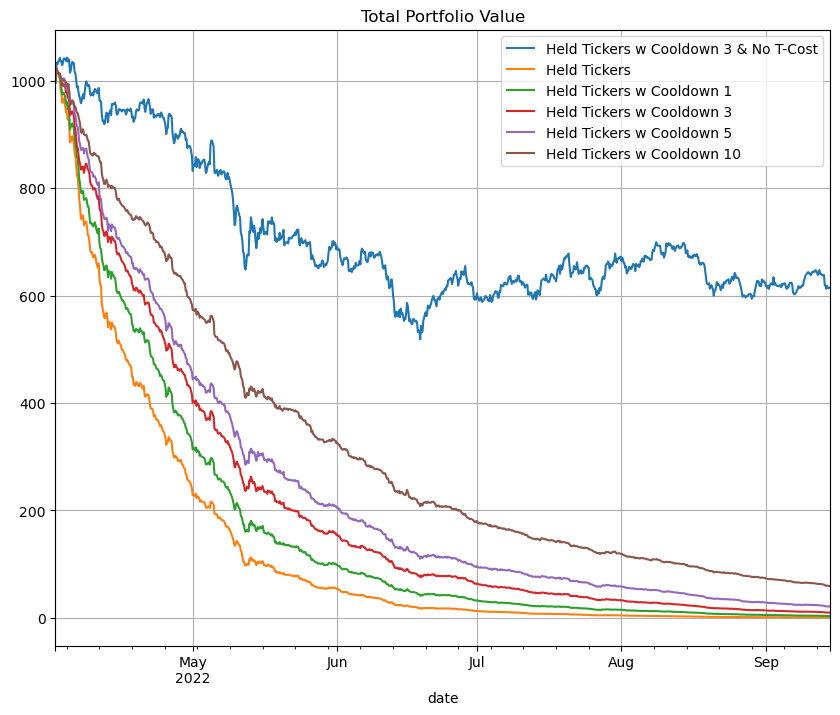

In [82]:
df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 3 & No T-Cost', legend=True)
df_daily_portfolio_with_t_cost_held_tickers['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 1', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 3', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 5', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 10', legend=True, title='Total Portfolio Value')

## Average Forward Return by Decile

   signal_decile      mean       std      n     tstat
0              0  0.000571  0.041397  24164  2.143720
1              1  0.000351  0.034979  24145  1.560822
2              2  0.000167  0.033932  24167  0.764824
3              3  0.000113  0.033033  24076  0.531072
4              4 -0.000073  0.033050  24108 -0.343178
5              5 -0.000140  0.032702  24104 -0.666957
6              6 -0.000233  0.033267  24089 -1.084823
7              7 -0.000459  0.034635  24059 -2.056940
8              8 -0.000570  0.036960  24055 -2.391333
9              9 -0.002577  0.048375  24073 -8.266812


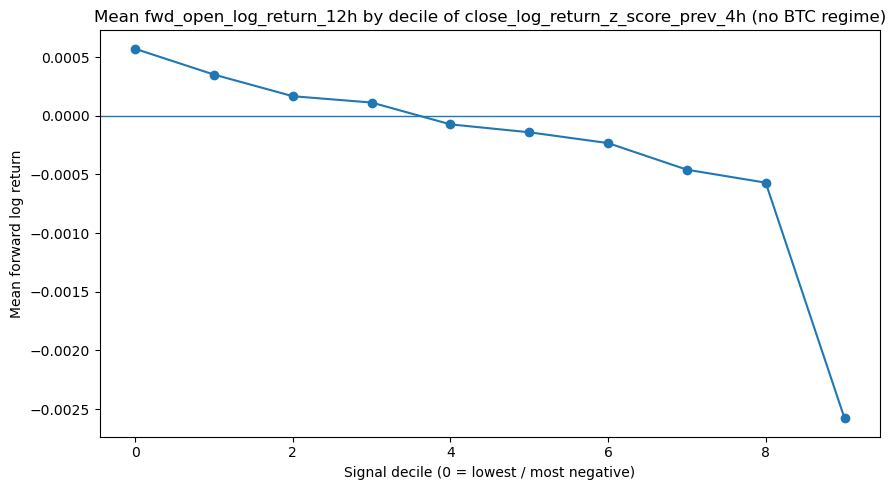

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def add_signal_deciles(
    df: pd.DataFrame,
    signal_col: str,
    date_col: str = "date",
    q: int = 10,
    decile_col: str = "signal_decile",
) -> pd.DataFrame:
    out = df.copy()

    def _qcut_safe(x: pd.Series) -> pd.Series:
        # qcut can fail when there are too many ties; duplicates="drop" helps
        try:
            return pd.qcut(x, q=q, labels=False, duplicates="drop")
        except ValueError:
            return pd.Series([np.nan] * len(x), index=x.index)

    out[decile_col] = out.groupby(date_col, group_keys=False)[signal_col].apply(_qcut_safe)
    return out


def decile_stats_overall(
    df: pd.DataFrame,
    fwd_ret_col: str,
    decile_col: str = "signal_decile",
) -> pd.DataFrame:
    d = df.dropna(subset=[decile_col, fwd_ret_col]).copy()
    d[decile_col] = d[decile_col].astype(int)

    g = d.groupby(decile_col)[fwd_ret_col]
    stats = g.agg(["mean", "std", "count"]).rename(columns={"count": "n"}).reset_index()
    stats["tstat"] = stats["mean"] / (stats["std"] / np.sqrt(stats["n"].clip(lower=1)))
    return stats.sort_values(decile_col)


def plot_decile_curve(stats_df: pd.DataFrame, title: str, decile_col: str = "signal_decile"):
    plt.figure(figsize=(9, 5))
    plt.plot(stats_df[decile_col], stats_df["mean"], marker="o")
    plt.axhline(0.0, linewidth=1)
    plt.title(title)
    plt.xlabel("Signal decile (0 = lowest / most negative)")
    plt.ylabel("Mean forward log return")
    plt.tight_layout()
    plt.show()


# -----------------------------
# Run it
# -----------------------------
# Pick the columns you want to diagnose:
# signal_col = "resid_btc_zscore_prev_4h"   # or "close_log_return_z_score_prev_4h"
signal_col = "close_log_return_z_score_prev_4h"   # or "close_log_return_z_score_prev_4h"
fwd_ret_col = "fwd_open_log_return_12h"   # make sure this matches your df column name

df_diag = df_signal.copy()
df_diag["date"] = pd.to_datetime(df_diag["date"])

# Add deciles
df_diag = add_signal_deciles(df_diag, signal_col=signal_col, date_col="date", q=10, decile_col="signal_decile")

# Compute stats
stats_overall = decile_stats_overall(df_diag, fwd_ret_col=fwd_ret_col, decile_col="signal_decile")

print(stats_overall)

# Optional plot
plot_decile_curve(stats_overall, title=f"Mean {fwd_ret_col} by decile of {signal_col} (no BTC regime)")


In [101]:
d0 = stats_overall.loc[stats_overall["signal_decile"] == 0, "mean"].values
d9 = stats_overall.loc[stats_overall["signal_decile"] == stats_overall["signal_decile"].max(), "mean"].values

if len(d0) and len(d9):
    print(f"Decile0 - TopDecile mean fwd return spread: {float(d0[0] - d9[0]):.6f}")


Decile0 - TopDecile mean fwd return spread: 0.003148


In [104]:
stats_overall

,signal_decile,mean,std,n,tstat
0,0,0.000571,0.041397,24164,2.143720
1,1,0.000351,0.034979,24145,1.560822
2,2,0.000167,0.033932,24167,0.764824
3,3,0.000113,0.033033,24076,0.531072
4,4,-0.000073,0.033050,24108,-0.343178
5,5,-0.000140,0.032702,24104,-0.666957
6,6,-0.000233,0.033267,24089,-1.084823
7,7,-0.000459,0.034635,24059,-2.056940
8,8,-0.000570,0.036960,24055,-2.391333
9,9,-0.002577,0.048375,24073,-8.266812


In [106]:
## Running Coin Level Diagnostics

def decile_stats_by_ticker(
    df: pd.DataFrame,
    fwd_ret_col: str,
    ticker_col: str = "ticker",
    decile_col: str = "signal_decile",
    min_n: int = 200,   # filter low-sample bins
) -> pd.DataFrame:
    """
    Returns stats by (ticker, decile): mean/std/n/tstat.
    Useful to see which coins dominate decile performance.
    """
    d = df.dropna(subset=[ticker_col, decile_col, fwd_ret_col]).copy()
    d[decile_col] = d[decile_col].astype(int)

    g = d.groupby([ticker_col, decile_col])[fwd_ret_col]
    stats = g.agg(["mean", "std", "count"]).rename(columns={"count": "n"}).reset_index()
    stats["tstat"] = stats["mean"] / (stats["std"] / np.sqrt(stats["n"].clip(lower=1)))

    # optional: drop tiny buckets to avoid noisy conclusions
    stats = stats[stats["n"] >= min_n].copy()
    return stats.sort_values([ticker_col, decile_col])


def summarize_decile_tail_contributors(
    stats_by_ticker: pd.DataFrame,
    decile: int,
    top_k: int = 10,
) -> pd.DataFrame:
    """
    For a given decile (e.g. 0 or 9), show tickers with largest absolute contribution signal
    in terms of mean return and sample size.
    """
    s = stats_by_ticker.loc[stats_by_ticker["signal_decile"] == decile].copy()
    # rank by |mean| first, tstat second (simple heuristic)
    s["abs_mean"] = s["mean"].abs()
    return s.sort_values(["abs_mean", "tstat"], ascending=[False, False]).head(top_k)


def ticker_level_spread(
    stats_by_ticker: pd.DataFrame,
    low_decile: int = 0,
    high_decile: int = 9,
) -> pd.DataFrame:
    """
    Computes per-ticker spread: mean(decile=low) - mean(decile=high).
    This tells you which tickers 'power' the cross-sectional spread.
    """
    a = stats_by_ticker.loc[stats_by_ticker["signal_decile"] == low_decile, ["ticker", "mean", "n"]].rename(
        columns={"mean": f"mean_d{low_decile}", "n": f"n_d{low_decile}"}
    )
    b = stats_by_ticker.loc[stats_by_ticker["signal_decile"] == high_decile, ["ticker", "mean", "n"]].rename(
        columns={"mean": f"mean_d{high_decile}", "n": f"n_d{high_decile}"}
    )
    m = a.merge(b, on="ticker", how="inner")
    m["spread"] = m[f"mean_d{low_decile}"] - m[f"mean_d{high_decile}"]
    return m.sort_values("spread", ascending=False)


In [108]:
# --- Coin-level diagnostics ---
stats_by_ticker = decile_stats_by_ticker(df_diag, fwd_ret_col=fwd_ret_col, ticker_col="ticker", decile_col="signal_decile", min_n=200)

# Who is driving the bottom decile (0) and top decile (9)?
print("\nTop contributors (by |mean|) in decile 0:")
print(summarize_decile_tail_contributors(stats_by_ticker, decile=0, top_k=15))

print("\nTop contributors (by |mean|) in decile 9:")
print(summarize_decile_tail_contributors(stats_by_ticker, decile=9, top_k=15))

# Per-ticker spread between decile 0 and 9
spread_by_ticker = ticker_level_spread(stats_by_ticker, low_decile=0, high_decile=9)
print("\nPer-ticker decile0 - decile9 spread (top 20):")
print(spread_by_ticker.head(20))

print("\nPer-ticker decile0 - decile9 spread (bottom 20):")
print(spread_by_ticker.tail(20))



Top contributors (by |mean|) in decile 0:
       ticker  signal_decile      mean       std     n     tstat  abs_mean
390   XTZ-USD              0 -0.007940  0.035710   276 -3.693723  0.007940
20    ADA-USD              0 -0.005372  0.037767   271 -2.341538  0.005372
100  COMP-USD              0  0.003611  0.035575   579  2.442300  0.003611
340   SOL-USD              0  0.003372  0.043304   558  1.839163  0.003372
290   REQ-USD              0 -0.003114  0.038512   693 -2.128309  0.003114
300  RNDR-USD              0  0.002587  0.048300  1209  1.862032  0.002587
170   FET-USD              0  0.002546  0.049650  1080  1.685259  0.002546
140  DOGE-USD              0  0.002545  0.042252   399  1.203149  0.002545
80    BAL-USD              0 -0.002283  0.030700   484 -1.635743  0.002283
30   AIOZ-USD              0  0.002195  0.053925  1555  1.605296  0.002195
90    BTC-USD              0  0.001877  0.021231   201  1.253335  0.001877
220   KRL-USD              0  0.001861  0.045141  1218  1

In [110]:
spread_by_ticker.head(20)

,ticker,mean_d0,n_d0,mean_d9,n_d9,spread
5,AMP-USD,0.001589,1059,-0.009385,813,0.010974
0,1INCH-USD,-0.000422,483,-0.010293,496,0.009871
3,AIOZ-USD,0.002195,1555,-0.006115,1334,0.008310
21,KRL-USD,0.001861,1218,-0.005786,1130,0.007648
10,COMP-USD,0.003611,579,-0.003800,600,0.007410
23,LRC-USD,-0.001700,405,-0.008892,389,0.007192
25,MANA-USD,0.001247,294,-0.005751,322,0.006998
35,SUSHI-USD,0.001667,580,-0.003140,591,0.004807
27,OXT-USD,-0.000616,795,-0.005176,726,0.004560
29,RNDR-USD,0.002587,1209,-0.001294,1119,0.003881


In [112]:
df_diag.head()

,ticker,date,low,high,open,close,volume,imputed,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket,bottom_quintile_signal,trade_signal,trade_signal_exec,signal_decile
223149,1INCH-USD,2022-04-01 08:00:00,1.738,1.772,1.757,1.747,43729.16,False,0.027146,0.152888,0.068196,7,False,0.0,0.0,7
223150,1INCH-USD,2022-04-01 12:00:00,1.710,1.831,1.744,1.816,149897.91,False,-0.004569,0.127891,0.074558,6,False,0.0,0.0,6
223151,1INCH-USD,2022-04-01 16:00:00,1.809,1.885,1.819,1.880,167483.50,False,0.038736,-0.044778,0.058196,5,False,0.0,0.0,5
223152,1INCH-USD,2022-04-01 20:00:00,1.856,1.890,1.881,1.882,219778.94,False,0.034635,0.904957,0.019479,8,False,0.0,0.0,8
223153,1INCH-USD,2022-04-02 00:00:00,1.869,1.953,1.879,1.928,228449.80,False,0.001063,0.306189,0.070872,6,False,0.0,0.0,6


## Run Large vs Small Liquidity Diagnostic Across Universe

In [114]:
def add_liquidity_proxy_and_bucket(
    df: pd.DataFrame,
    date_col: str = "date",
    ticker_col: str = "ticker",
    close_col: str = "close",
    volume_col: str = "volume",         # optional; if missing we'll fall back
    ret_col_for_vol: str = "close_log_return_prev_4h",
    bars_per_day: int = 6,
    window_days: int = 30,
    top_n: int = 15,
    lag_bars: int = 1,
    bucket_col: str = "cap_bucket",
) -> pd.DataFrame:
    """
    Creates a 'large vs small' bucket.
    - Preferred: rolling $-volume (close*volume) if volume exists.
    - Fallback: rolling realized vol (higher vol => 'small/noisy') if volume not available.

    Bucket assignment is done *per timestamp* using only past info (lagged).
    """
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col])
    out = out.sort_values([ticker_col, date_col])

    window_bars = int(window_days * bars_per_day)

    has_volume = volume_col in out.columns and out[volume_col].notna().any()

    if has_volume:
        out["dollar_vol"] = out[close_col].astype(float) * out[volume_col].astype(float)
        out["liq_proxy"] = (
            out.groupby(ticker_col)["dollar_vol"]
               .rolling(window_bars, min_periods=max(10, window_bars // 3))
               .mean()
               .reset_index(level=0, drop=True)
        )
        # no-lookahead
        out["liq_proxy"] = out.groupby(ticker_col)["liq_proxy"].shift(lag_bars)
        # larger liq_proxy => more "large-cap-like"
        proxy_col = "liq_proxy"
        ascending = False  # rank high first
    else:
        # fallback: realized vol; lower vol => more "large-cap-like"
        out["vol_proxy"] = (
            out.groupby(ticker_col)[ret_col_for_vol]
               .rolling(window_bars, min_periods=max(10, window_bars // 3))
               .std()
               .reset_index(level=0, drop=True)
        )
        out["vol_proxy"] = out.groupby(ticker_col)["vol_proxy"].shift(lag_bars)
        proxy_col = "vol_proxy"
        ascending = True   # rank low first

    # assign bucket per timestamp
    def _bucket_one_timestamp(g: pd.DataFrame) -> pd.DataFrame:
        gg = g.copy()
        gg["rank"] = gg[proxy_col].rank(method="first", ascending=ascending)
        gg[bucket_col] = np.where(gg["rank"] <= top_n, "LARGE", "SMALL")
        return gg.drop(columns=["rank"])

    out = out.groupby(date_col, group_keys=False).apply(_bucket_one_timestamp)
    return out


def decile_stats_by_bucket(
    df: pd.DataFrame,
    fwd_ret_col: str,
    bucket_col: str,
    decile_col: str = "signal_decile",
) -> pd.DataFrame:
    d = df.dropna(subset=[bucket_col, decile_col, fwd_ret_col]).copy()
    d[decile_col] = d[decile_col].astype(int)

    g = d.groupby([bucket_col, decile_col])[fwd_ret_col]
    stats = g.agg(["mean", "std", "count"]).rename(columns={"count": "n"}).reset_index()
    stats["tstat"] = stats["mean"] / (stats["std"] / np.sqrt(stats["n"].clip(lower=1)))
    return stats.sort_values([bucket_col, decile_col])


def plot_decile_curves_by_bucket(stats_df: pd.DataFrame, bucket_col: str, title: str, decile_col: str = "signal_decile"):
    plt.figure(figsize=(10, 6))
    for b, g in stats_df.groupby(bucket_col):
        g = g.sort_values(decile_col)
        plt.plot(g[decile_col], g["mean"], marker="o", label=str(b))
    plt.axhline(0.0, linewidth=1)
    plt.title(title)
    plt.xlabel("Signal decile (0 = lowest / most negative)")
    plt.ylabel("Mean forward log return")
    plt.legend()
    plt.tight_layout()
    plt.show()


   cap_bucket  signal_decile      mean       std      n     tstat
0       LARGE              0  0.000035  0.036459  11937  0.105267
1       LARGE              1  0.000412  0.034195   5972  0.932217
2       LARGE              2 -0.000212  0.031237  11929 -0.742622
3       LARGE              3  0.000253  0.031378   5975  0.623520
4       LARGE              4 -0.000281  0.030887  11928 -0.993676
5       LARGE              5  0.000483  0.031690   5965  1.177141
6       LARGE              6  0.000068  0.031283   5972  0.167041
7       LARGE              7 -0.000238  0.032473  11923 -0.801083
8       LARGE              8 -0.000586  0.033074   5969 -1.367937
9       LARGE              9 -0.000714  0.040438  11920 -1.927104
10      SMALL              0  0.000853  0.042104  18190  2.731494
11      SMALL              1  0.000401  0.036054  12248  1.229876
12      SMALL              2  0.000209  0.034799  18182  0.807948
13      SMALL              3  0.000059  0.034270  12175  0.190783
14      SM

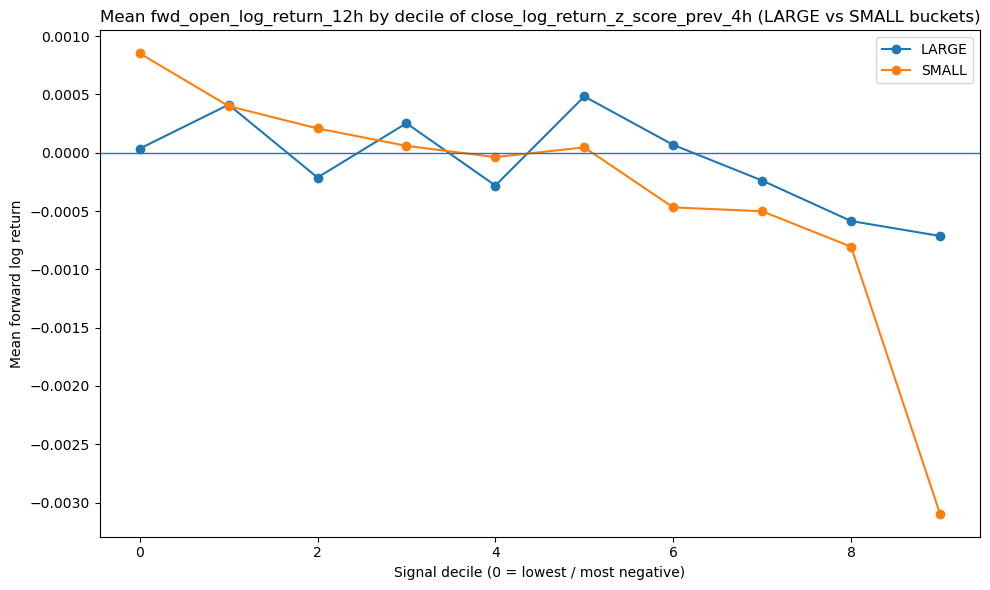


Decile0 - Decile9 spread by bucket:
cap_bucket
SMALL    0.003949
LARGE    0.000749
dtype: float64


In [116]:
signal_col = "close_log_return_z_score_prev_4h"
fwd_ret_col = "fwd_open_log_return_12h"

df_diag = df_signal.copy()
df_diag["date"] = pd.to_datetime(df_diag["date"])

# (A) Add LARGE/SMALL bucket (uses volume if present; else realized-vol proxy)
df_diag = add_liquidity_proxy_and_bucket(
    df_diag,
    date_col="date",
    ticker_col="ticker",
    close_col="close",
    volume_col="volume",                 # ok if missing
    ret_col_for_vol="close_log_return_prev_4h",
    bars_per_day=6,
    window_days=30,
    top_n=15,
    lag_bars=1,
    bucket_col="cap_bucket",
)

# (B) Run decile diagnostic separately by bucket:
#     Important: recompute deciles WITHIN each bucket each timestamp
df_bucket = df_diag.dropna(subset=["cap_bucket"]).copy()
df_bucket["signal_decile"] = (
    df_bucket.groupby(["date", "cap_bucket"], group_keys=False)[signal_col]
             .apply(lambda s: pd.qcut(s, q=10, labels=False, duplicates="drop"))
)

stats_bucket = decile_stats_by_bucket(df_bucket, fwd_ret_col=fwd_ret_col, bucket_col="cap_bucket", decile_col="signal_decile")
print(stats_bucket)

plot_decile_curves_by_bucket(
    stats_bucket,
    bucket_col="cap_bucket",
    title=f"Mean {fwd_ret_col} by decile of {signal_col} (LARGE vs SMALL buckets)"
)

# Optional: spread per bucket (D0 - D9)
spread_bucket = (
    stats_bucket.pivot(index="signal_decile", columns="cap_bucket", values="mean")
)
if 0 in spread_bucket.index and 9 in spread_bucket.index:
    print("\nDecile0 - Decile9 spread by bucket:")
    print((spread_bucket.loc[0] - spread_bucket.loc[9]).sort_values(ascending=False))


## Plotting Decile Time Series for Large vs Small

In [122]:
def build_decile_return_timeseries(
    df: pd.DataFrame,
    signal_col: str,
    fwd_ret_col: str,
    date_col: str = "date",
    q: int = 10,
    decile_col: str = "signal_decile",
    group_cols: list = None,   # e.g. ["cap_bucket"] or None
) -> pd.DataFrame:
    """
    Returns a time series DataFrame indexed by date with columns:
      - decile_0 ... decile_{q-1}
      - spread_d0_d{q-1}
    If group_cols is provided, returns a MultiIndex columns (group, decile_k).
    """
    d = df.dropna(subset=[date_col, signal_col, fwd_ret_col]).copy()
    d[date_col] = pd.to_datetime(d[date_col])

    # assign deciles cross-sectionally (optionally within bucket each timestamp)
    if group_cols:
        d[decile_col] = (
            d.groupby([date_col] + group_cols, group_keys=False)[signal_col]
             .apply(lambda s: pd.qcut(s, q=q, labels=False, duplicates="drop"))
        )
        d = d.dropna(subset=[decile_col])
        d[decile_col] = d[decile_col].astype(int)

        # average forward returns by (date, group, decile)
        ts = (
            d.groupby([date_col] + group_cols + [decile_col])[fwd_ret_col]
             .mean()
             .reset_index()
        )

        # pivot to wide
        ts_wide = ts.pivot_table(index=date_col, columns=group_cols + [decile_col], values=fwd_ret_col)
        # rename decile level to decile_k
        ts_wide.columns = pd.MultiIndex.from_tuples(
            [(g, f"decile_{k}") for g, k in ts_wide.columns],
            names=group_cols + ["decile"]
        )

        # compute spread per group
        for g in ts[group_cols[0]].unique():
            if (g, "decile_0") in ts_wide.columns and (g, f"decile_{q-1}") in ts_wide.columns:
                ts_wide[(g, f"spread_d0_d{q-1}")] = ts_wide[(g, "decile_0")] - ts_wide[(g, f"decile_{q-1}")]

        ts_wide = ts_wide.sort_index()
        return ts_wide

    else:
        d[decile_col] = (
            d.groupby(date_col, group_keys=False)[signal_col]
             .apply(lambda s: pd.qcut(s, q=q, labels=False, duplicates="drop"))
        )
        d = d.dropna(subset=[decile_col])
        d[decile_col] = d[decile_col].astype(int)

        ts = (
            d.groupby([date_col, decile_col])[fwd_ret_col]
             .mean()
             .unstack(decile_col)
             .sort_index()
        )
        ts.columns = [f"decile_{c}" for c in ts.columns]

        if "decile_0" in ts.columns and f"decile_{q-1}" in ts.columns:
            ts[f"spread_d0_d{q-1}"] = ts["decile_0"] - ts[f"decile_{q-1}"]

        return ts


def cumulate_log_returns(x: pd.Series) -> pd.Series:
    # if forward returns are log returns, cumulative log return is cumsum
    return x.cumsum()


def plot_cumulative_curves(ts: pd.DataFrame, cols: list, title: str):
    plt.figure(figsize=(11, 6))
    for c in cols:
        if c in ts.columns:
            plt.plot(ts.index, cumulate_log_returns(ts[c]), label=c)
    plt.axhline(0.0, linewidth=1)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


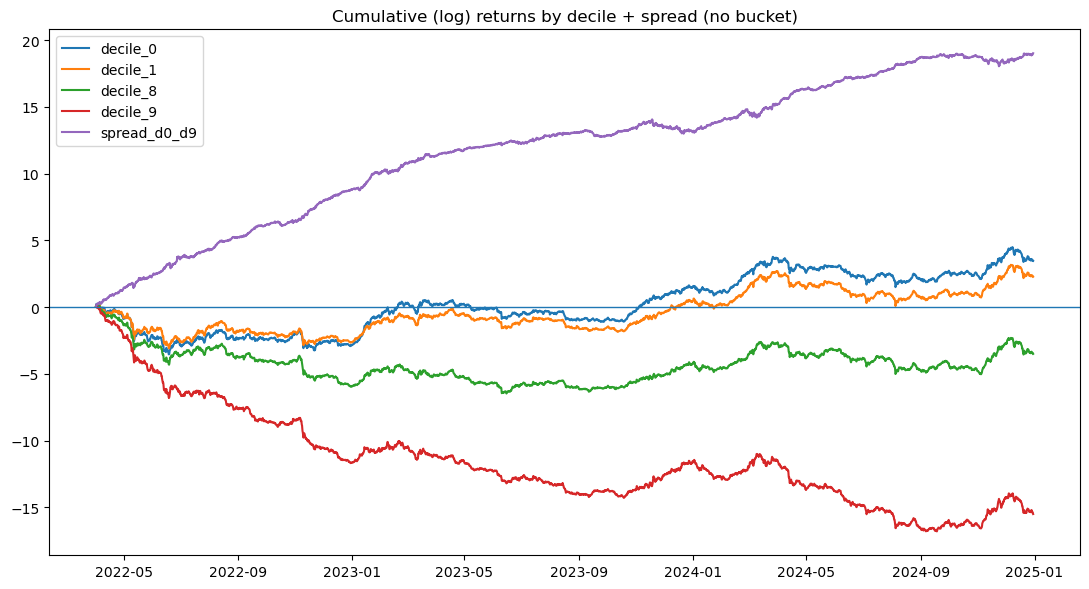

In [126]:
signal_col = "close_log_return_z_score_prev_4h"
fwd_ret_col = "fwd_open_log_return_12h"

ts = build_decile_return_timeseries(
    df=df_diag,
    signal_col=signal_col,
    fwd_ret_col=fwd_ret_col,
    date_col="date",
    q=10,
    group_cols=None
)

plot_cumulative_curves(
    ts,
    cols=["decile_0", "decile_1", "decile_8", "decile_9", "spread_d0_d9"],
    title=f"Cumulative (log) returns by decile + spread (no bucket)"
)


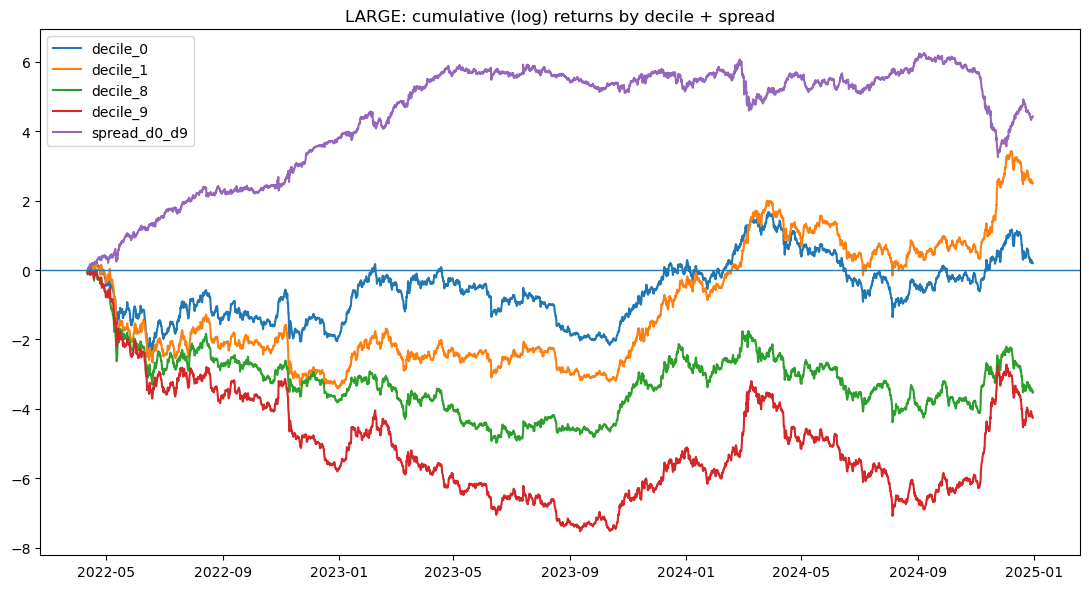

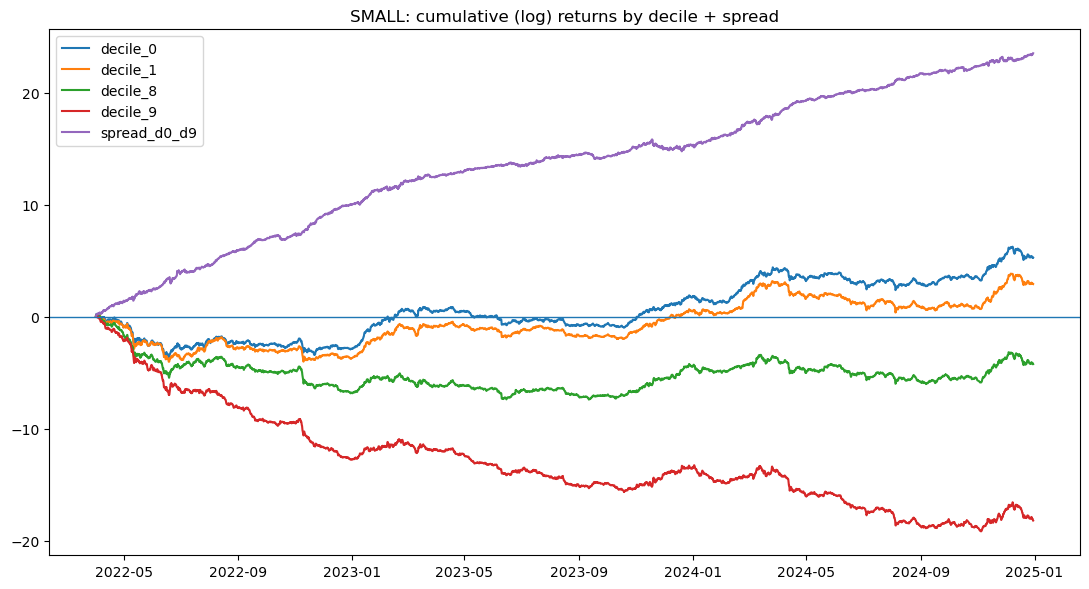

In [128]:
ts_bucket = build_decile_return_timeseries(
    df=df_diag.dropna(subset=["cap_bucket"]),
    signal_col=signal_col,
    fwd_ret_col=fwd_ret_col,
    date_col="date",
    q=10,
    group_cols=["cap_bucket"]
)

# Plot for each bucket separately
for bucket in ["LARGE", "SMALL"]:
    cols = [(bucket, "decile_0"), (bucket, "decile_1"), (bucket, "decile_8"), (bucket, "decile_9"), (bucket, "spread_d0_d9")]
    # keep only those that exist
    cols = [c for c in cols if c in ts_bucket.columns]
    plt.figure(figsize=(11, 6))
    for c in cols:
        plt.plot(ts_bucket.index, ts_bucket[c].cumsum(), label=str(c[1]))
    plt.axhline(0.0, linewidth=1)
    plt.title(f"{bucket}: cumulative (log) returns by decile + spread")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Rolling Performance Metrics for Large vs Small Coins

In [131]:
# Try to reuse your module
from portfolio import strategy_performance as perf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_bucket_spread_returns(
    df: pd.DataFrame,
    fwd_log_ret_col: str = "fwd_open_log_return_12h",
    bucket_col: str = "cap_bucket",
    decile_col: str = "signal_decile",
    date_col: str = "date",
    long_decile: int = 0,
    short_decile: int = 9,
    half_gross: bool = True,   # True => return on $2 gross; False => per-leg PnL (long-short)
):
    d = df.dropna(subset=[date_col, bucket_col, decile_col, fwd_log_ret_col]).copy()
    d[date_col] = pd.to_datetime(d[date_col])

    # Use SIMPLE forward returns for compounding metrics
    d["fwd_simple_ret"] = np.expm1(d[fwd_log_ret_col].astype(float))

    # mean return per (date, bucket, decile)
    g = (
        d.groupby([date_col, bucket_col, decile_col])["fwd_simple_ret"]
         .mean()
         .reset_index()
    )

    piv = g.pivot_table(index=date_col, columns=[bucket_col, decile_col], values="fwd_simple_ret").sort_index()

    out = {}
    for b in sorted(d[bucket_col].unique()):
        if (b, long_decile) not in piv.columns or (b, short_decile) not in piv.columns:
            continue
        long_ret = piv[(b, long_decile)]
        short_ret = piv[(b, short_decile)]
        spread = long_ret - short_ret
        if half_gross:
            spread = 0.5 * spread

        df_spread = pd.DataFrame(
            {
                "spread_return": spread,
                "trade_count": np.where(spread.notna(), 1.0, 0.0),
            },
            index=spread.index,
        )
        out[b] = df_spread

    return out


In [133]:
def rolling_max_drawdown_from_returns(r: pd.Series, window: int, min_periods: int = None) -> pd.Series:
    rr = r.dropna()
    if min_periods is None:
        min_periods = max(20, window // 3)

    def _mdd(x):
        # equity curve inside window (start at 1)
        eq = np.cumprod(1.0 + x)
        peak = np.maximum.accumulate(eq)
        dd = (eq / peak) - 1.0
        return float(dd.min())

    return rr.rolling(window, min_periods=min_periods).apply(_mdd, raw=True)


def compute_rolling_spread_metrics(
    df_spread: pd.DataFrame,
    window: int,
    annual_trading_days: int,
    annual_rf: float = 0.0,
):
    # Reuse your module's rolling Sharpe (set costs off)
    roll_sharpe = perf.rolling_sharpe_ratio(
        df_spread,
        window=window,
        strategy_daily_return_col="spread_return",
        strategy_trade_count_col="trade_count",
        min_trade_count=0,  # important for shorter windows
        annual_trading_days=annual_trading_days,
        annual_rf=annual_rf,
        include_transaction_costs_and_fees=False,
    )

    r = df_spread["spread_return"]

    roll_mean = r.rolling(window, min_periods=max(20, window // 3)).mean()
    roll_vol  = r.rolling(window, min_periods=max(20, window // 3)).std() * np.sqrt(annual_trading_days)
    roll_hit  = r.rolling(window, min_periods=max(20, window // 3)).apply(lambda x: np.mean(x > 0), raw=True)
    roll_mdd  = rolling_max_drawdown_from_returns(r, window=window)

    out = pd.DataFrame(
        {
            "roll_sharpe": roll_sharpe,
            "roll_mean_per_bar": roll_mean,
            "roll_ann_vol": roll_vol,
            "roll_hit_rate": roll_hit,
            "roll_mdd": roll_mdd,  # negative
        }
    )
    return out


def summarize_rolling_sharpe(roll_sharpe: pd.Series) -> dict:
    s = roll_sharpe.dropna()
    return {
        "pct_sharpe_pos": float((s > 0).mean()),
        "pct_sharpe_gt_1": float((s > 1).mean()),
        "pct_sharpe_gt_2": float((s > 2).mean()),
        "median": float(s.median()),
        "p10": float(s.quantile(0.10)),
        "p90": float(s.quantile(0.90)),
    }


def plot_rolling_panels(m: pd.DataFrame, title: str):
    fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)

    axes[0].plot(m.index, m["roll_sharpe"])
    axes[0].axhline(0, linewidth=1)
    axes[0].set_title(f"{title} | Rolling Sharpe")

    axes[1].plot(m.index, m["roll_mean_per_bar"])
    axes[1].axhline(0, linewidth=1)
    axes[1].set_title("Rolling mean (per bar)")

    axes[2].plot(m.index, m["roll_hit_rate"])
    axes[2].axhline(0.5, linewidth=1)
    axes[2].set_title("Rolling hit rate")

    axes[3].plot(m.index, m["roll_mdd"])
    axes[3].axhline(0, linewidth=1)
    axes[3].set_title("Rolling max drawdown (window)")

    plt.tight_layout()
    plt.show()



=== LARGE ===  n_bars=5960
--- 14D window --- {'pct_sharpe_pos': 0.6251488854857921, 'pct_sharpe_gt_1': 0.5623617491917645, 'pct_sharpe_gt_2': 0.48477114173898245, 'median': 1.7948792332091736, 'p10': -5.674689350160666, 'p90': 8.267598542480599}


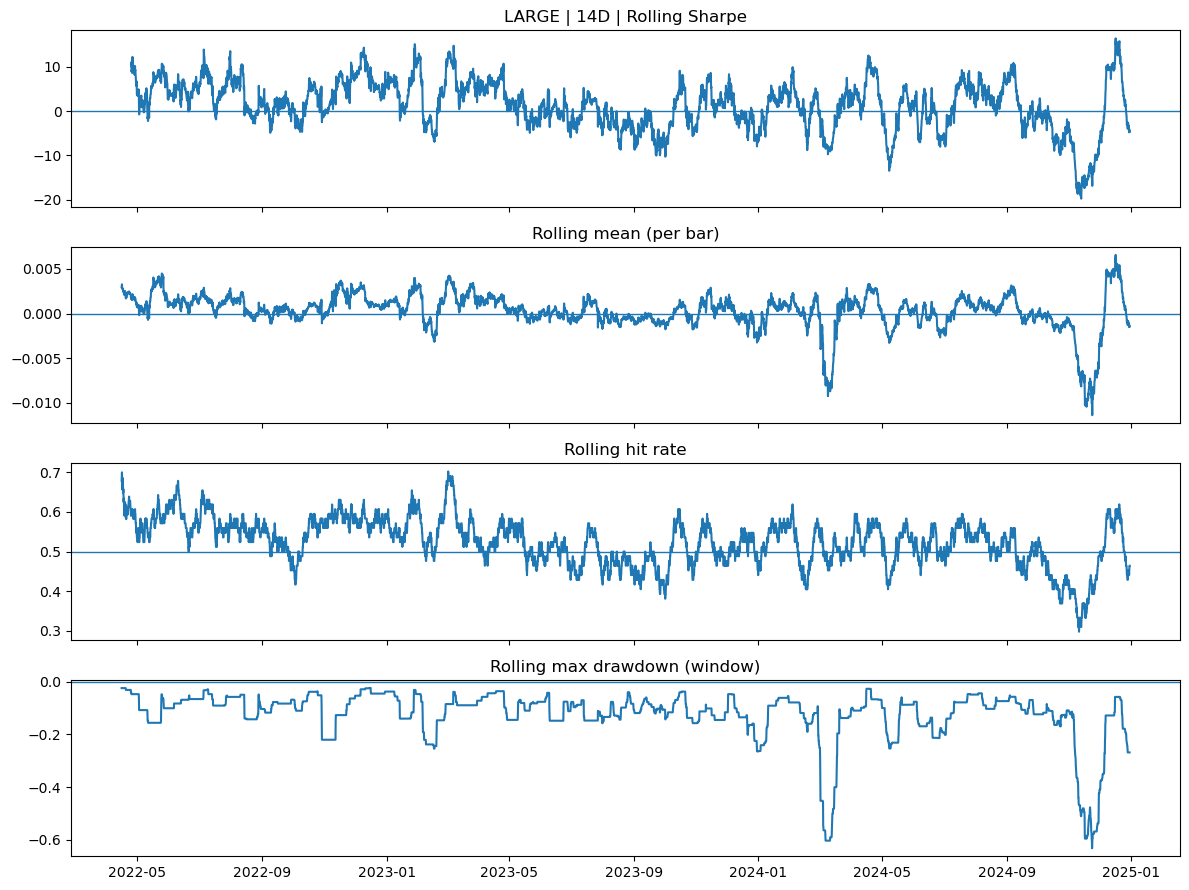

--- 30D window --- {'pct_sharpe_pos': 0.6422764227642277, 'pct_sharpe_gt_1': 0.5336446981491092, 'pct_sharpe_gt_2': 0.44680851063829785, 'median': 1.3675226445595081, 'p10': -3.8225236850961757, 'p90': 6.188612440499925}


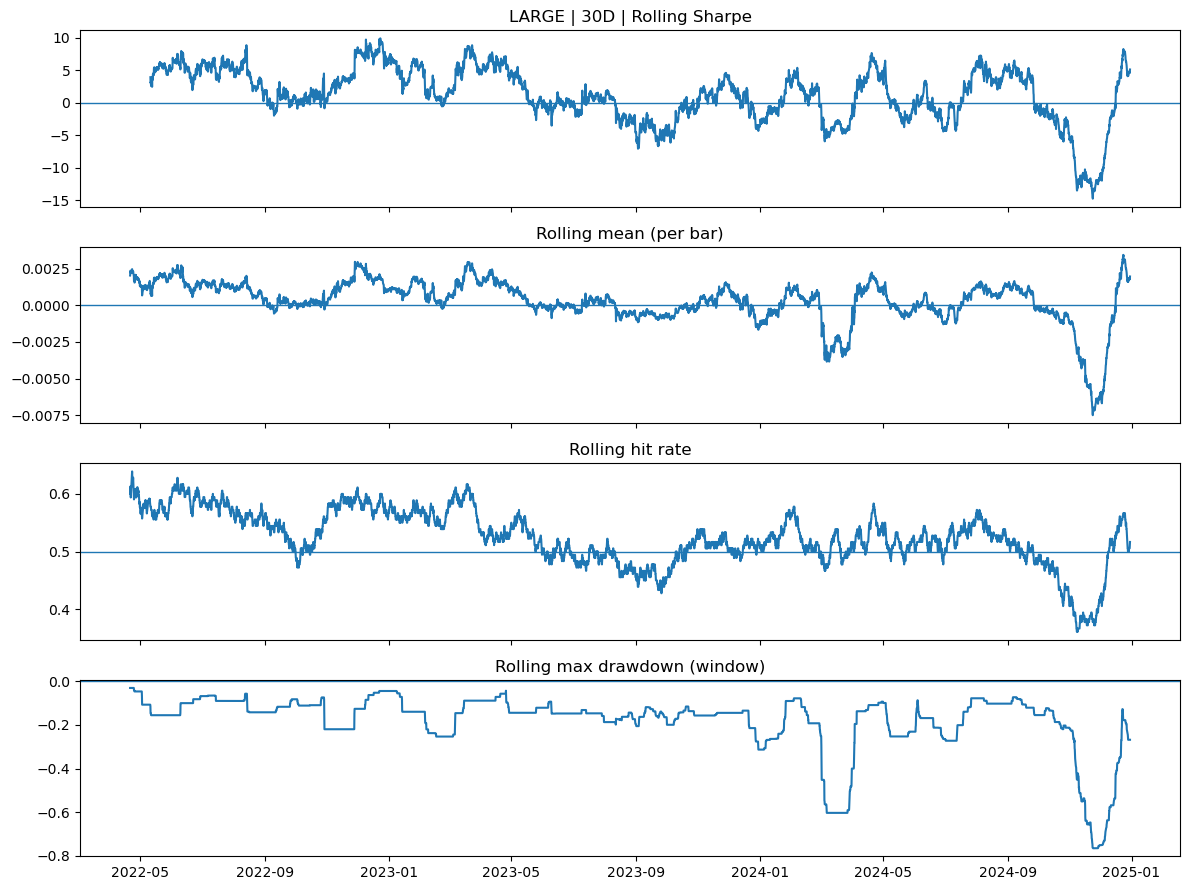

--- 90D window --- {'pct_sharpe_pos': 0.6541228555617045, 'pct_sharpe_gt_1': 0.4886552296624239, 'pct_sharpe_gt_2': 0.3835085777531821, 'median': 0.8857103047101518, 'p10': -1.7393358529354634, 'p90': 4.529835575180799}


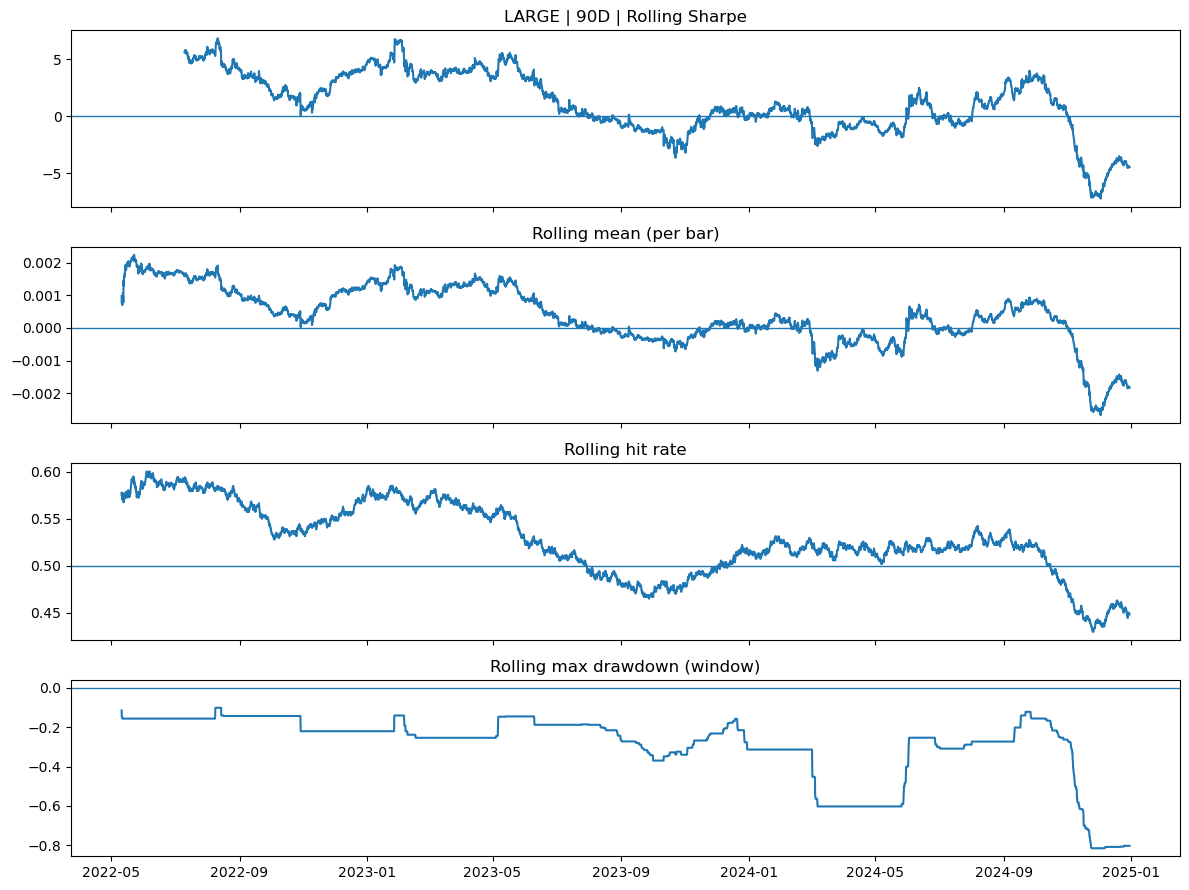


=== SMALL ===  n_bars=5987
--- 14D window --- {'pct_sharpe_pos': 0.883130081300813, 'pct_sharpe_gt_1': 0.8468834688346883, 'pct_sharpe_gt_2': 0.796239837398374, 'median': 6.178792271849078, 'p10': -0.5359767152877918, 'p90': 13.100597193477734}


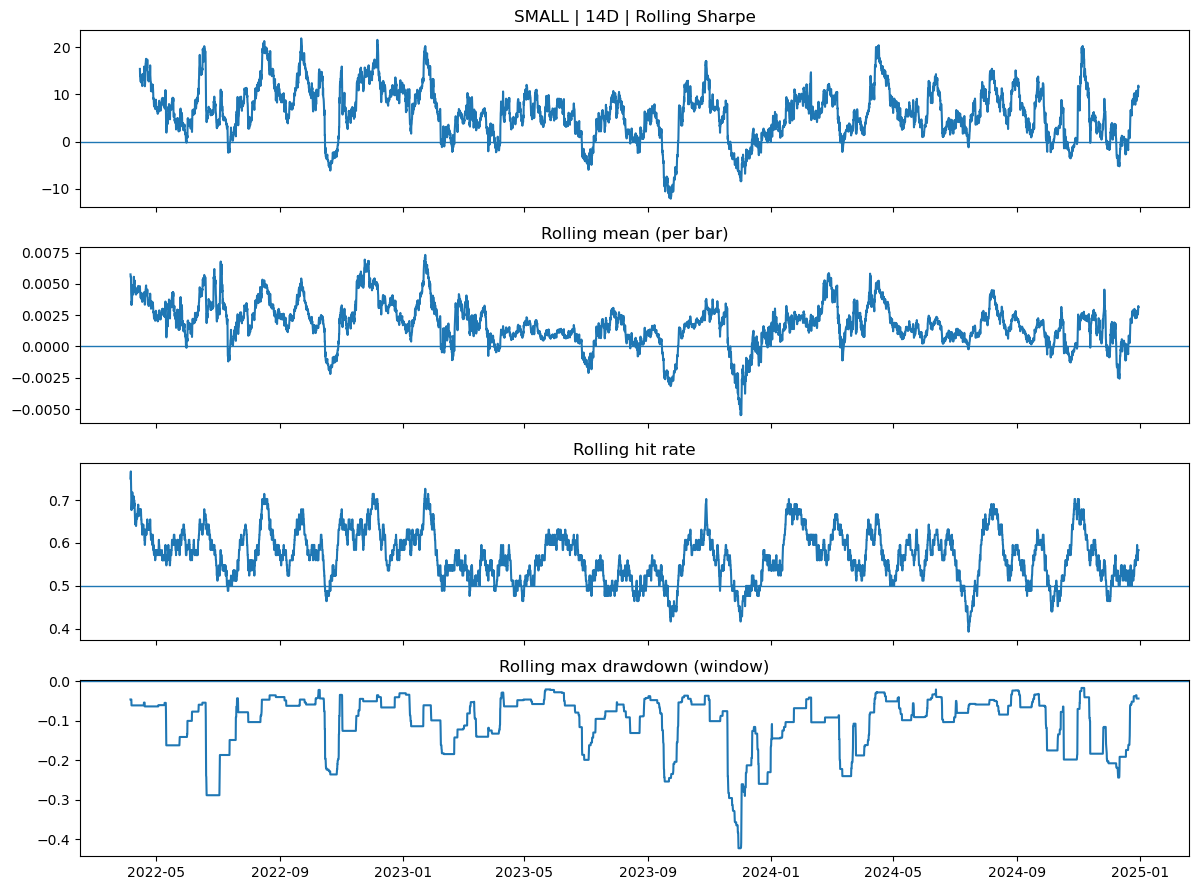

--- 30D window --- {'pct_sharpe_pos': 0.9257920110192838, 'pct_sharpe_gt_1': 0.8767217630853994, 'pct_sharpe_gt_2': 0.8269628099173554, 'median': 5.598046636411659, 'p10': 0.5057073818200271, 'p90': 10.940681147166824}


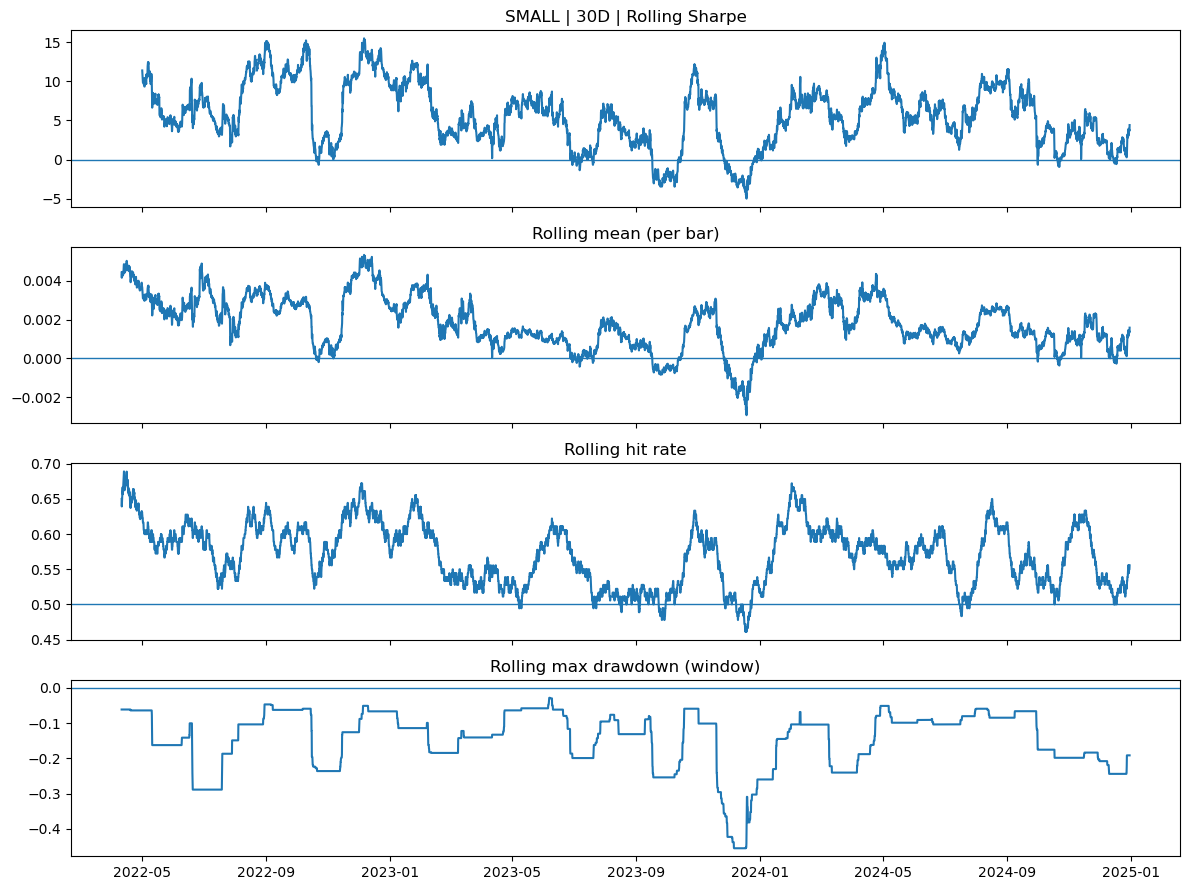

--- 90D window --- {'pct_sharpe_pos': 1.0, 'pct_sharpe_gt_1': 0.9631057268722467, 'pct_sharpe_gt_2': 0.8869309838472834, 'median': 5.42986149891156, 'p10': 1.655245498174501, 'p90': 8.268101761510666}


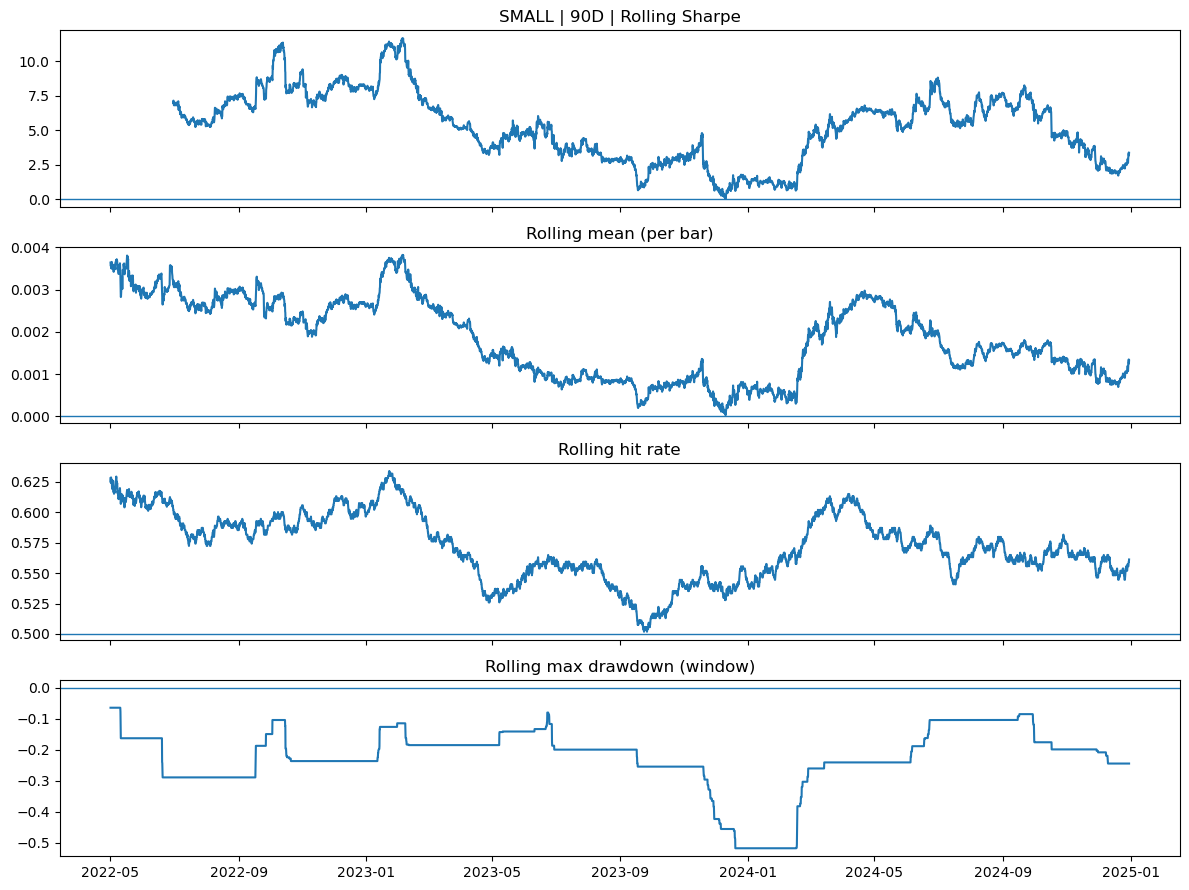

In [143]:
bars_per_day = 6                 # 4h bars
annual_trading_days = 365 * 6    # ~2190 “bars/year”
windows_days = [14, 30, 90]
windows = [w * bars_per_day for w in windows_days]

bucket_series = build_bucket_spread_returns(
    df=df_bucket,
    fwd_log_ret_col="fwd_open_log_return_12h",
    bucket_col="cap_bucket",
    decile_col="signal_decile",
    date_col="date",
    long_decile=0,
    short_decile=9,
    half_gross=True,   # recommended convention
)

for bucket_name in ["LARGE", "SMALL"]:
    df_sp = bucket_series[bucket_name].dropna()
    print(f"\n=== {bucket_name} ===  n_bars={len(df_sp)}")

    for w_days, w in zip(windows_days, windows):
        m = compute_rolling_spread_metrics(
            df_spread=df_sp,
            window=w,
            annual_trading_days=annual_trading_days,
            annual_rf=0.0,
        )
        print(f"--- {w_days}D window ---", summarize_rolling_sharpe(m["roll_sharpe"]))
        plot_rolling_panels(m, title=f"{bucket_name} | {w_days}D")


<Axes: xlabel='date'>

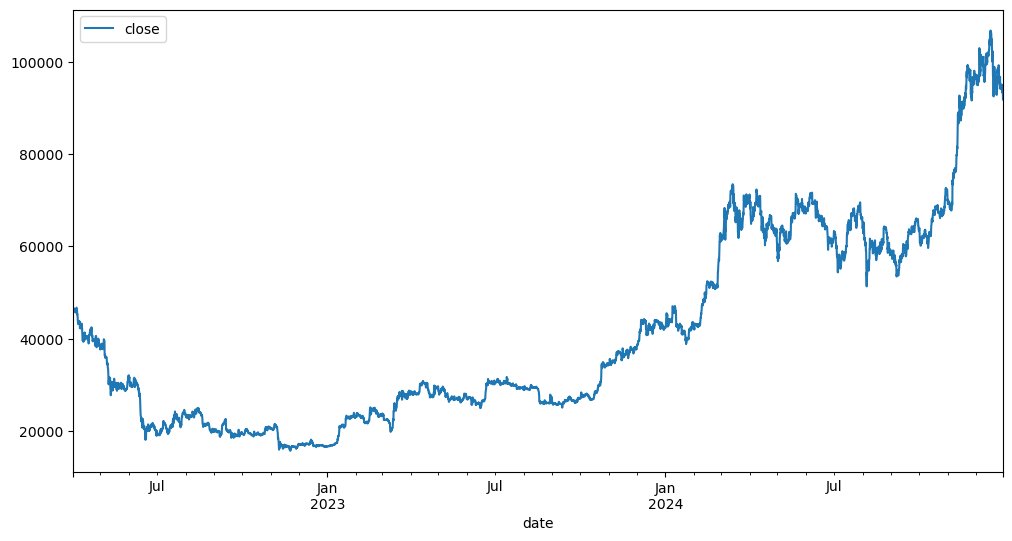

In [172]:
df_bucket[df_bucket['ticker'] == 'BTC-USD'][['date','close']].set_index('date').plot(figsize=(12,6))#.head()

## Simple Regime Filter Implementation

In [146]:
import numpy as np
import pandas as pd

def build_btc_regime_simple(
    df: pd.DataFrame,
    btc_ticker: str = "BTC-USD",
    date_col: str = "date",
    ticker_col: str = "ticker",
    close_col: str = "close",
    bars_per_day: int = 6,
    trend_days: int = 14,      # trend lookback (days)
    vol_days: int = 14,        # vol lookback (days)
    vol_ref_days: int = 90,    # rolling baseline for "high vol" threshold
):
    """
    Returns DataFrame indexed by date with:
      btc_ret_lag1, btc_trend, btc_vol, btc_high_vol, btc_regime
    Regime = {UP,DOWN}_{LV,HV}
    All features use LAGGED BTC returns to avoid lookahead at time t.
    """
    btc = (
        df.loc[df[ticker_col] == btc_ticker, [date_col, close_col]]
        .drop_duplicates(subset=[date_col])
        .sort_values(date_col)
        .copy()
    )
    btc[date_col] = pd.to_datetime(btc[date_col])
    btc = btc.set_index(date_col)

    btc["btc_ret"] = np.log(btc[close_col] / btc[close_col].shift(1))
    btc["btc_ret_lag1"] = btc["btc_ret"].shift(1)  # last fully formed bar return

    r = btc["btc_ret_lag1"]

    trend_w = trend_days * bars_per_day
    vol_w   = vol_days * bars_per_day
    ref_w   = vol_ref_days * bars_per_day

    btc["btc_trend"] = r.rolling(trend_w, min_periods=trend_w).sum()
    btc["btc_vol"]   = r.rolling(vol_w,   min_periods=vol_w).std()

    # “high vol” if current vol > rolling median vol baseline
    btc["btc_vol_ref"]  = btc["btc_vol"].rolling(ref_w, min_periods=ref_w).median()
    btc["btc_high_vol"] = btc["btc_vol"] > btc["btc_vol_ref"]

    btc_trend_sign = np.where(btc["btc_trend"] >= 0, "UP", "DOWN")
    btc_vol_state  = np.where(btc["btc_high_vol"], "HV", "LV")
    btc["btc_regime"] = pd.Series(btc_trend_sign, index=btc.index) + "_" + pd.Series(btc_vol_state, index=btc.index)

    return btc[["btc_ret_lag1","btc_trend","btc_vol","btc_high_vol","btc_regime"]]

In [148]:
def compute_decile_spread_series(
    df: pd.DataFrame,
    cap_bucket_value: str,                 # "LARGE" or "SMALL"
    date_col: str = "date",
    bucket_col: str = "cap_bucket",
    decile_col: str = "signal_decile",
    fwd_ret_col: str = "fwd_open_log_return_12h",
    long_decile: int = 0,
    short_decile: int = 9,
    stride: int | None = None,             # set stride=3 to reduce overlap (non-overlapping entries)
):
    d = df.loc[df[bucket_col] == cap_bucket_value].dropna(subset=[date_col, decile_col, fwd_ret_col]).copy()
    d[date_col] = pd.to_datetime(d[date_col])

    # mean fwd return per decile per timestamp
    piv = d.pivot_table(index=date_col, columns=decile_col, values=fwd_ret_col, aggfunc="mean")

    if long_decile not in piv.columns or short_decile not in piv.columns:
        raise ValueError(f"Missing decile columns in pivot: need {long_decile} and {short_decile}")

    out = pd.DataFrame(index=piv.index)
    out["ret_long_d0"]  = piv[long_decile]
    out["ret_short_d9"] = piv[short_decile]
    out["spread_d0_d9"] = out["ret_long_d0"] - out["ret_short_d9"]

    out = out.sort_index().dropna(subset=["spread_d0_d9"])

    # Optional: reduce overlap in “trade-level” returns (recommended sanity check)
    if stride is not None and stride > 1:
        out = out.iloc[::stride].copy()

    return out


In [150]:
def summarize_by_regime(
    spread_df: pd.DataFrame,
    btc_regime_df: pd.DataFrame,
    ret_col: str = "spread_d0_d9",
    regime_col: str = "btc_regime",
    bars_per_year: int = 365 * 6,   # 4h bars
):
    x = spread_df.join(btc_regime_df[[regime_col]], how="inner").dropna(subset=[regime_col, ret_col]).copy()

    g = x.groupby(regime_col)[ret_col]
    summary = g.agg(["mean","std","count"]).rename(columns={"count":"n"})

    # Sharpe (approx; overlap exists if you didn't stride)
    summary["sharpe"] = np.sqrt(bars_per_year) * (summary["mean"] / summary["std"].replace(0, np.nan))
    summary["hit_rate"] = x.groupby(regime_col)[ret_col].apply(lambda s: (s > 0).mean())
    summary["frac_time"] = summary["n"] / summary["n"].sum()

    return summary.sort_values("sharpe", ascending=False)

In [152]:
def pick_allowed_regimes(
    regime_summary: pd.DataFrame,
    min_frac_time: float = 0.05,
    min_sharpe: float = 0.0,
    min_mean: float = 0.0,
):
    ok = (
        (regime_summary["frac_time"] >= min_frac_time) &
        (regime_summary["sharpe"] >= min_sharpe) &
        (regime_summary["mean"] >= min_mean)
    )
    return regime_summary.index[ok].tolist()


def apply_regime_gate(
    spread_df: pd.DataFrame,
    btc_regime_df: pd.DataFrame,
    allowed_regimes: list[str],
    ret_col: str = "spread_d0_d9",
    regime_col: str = "btc_regime",
):
    x = spread_df.join(btc_regime_df[[regime_col]], how="inner").copy()
    x["regime_ok"] = x[regime_col].isin(set(allowed_regimes))
    x["ret_gated"] = np.where(x["regime_ok"], x[ret_col], 0.0)
    return x


In [158]:
# Inputs you already have:
# df_diag has: date, ticker, cap_bucket, signal_decile, fwd_open_log_return_12h, close (for BTC rows)

btc_reg = build_btc_regime_simple(
    df=df_bucket,
    btc_ticker="BTC-USD",
    date_col="date",
    ticker_col="ticker",
    close_col="close",
    bars_per_day=6,
    trend_days=14,
    vol_days=14,
    vol_ref_days=90,
)

# Optional sanity: set stride=3 to reduce overlap (since fwd is 12h)
spread_large = compute_decile_spread_series(df_bucket, "LARGE", stride=3)
spread_small = compute_decile_spread_series(df_bucket, "SMALL", stride=3)

sum_large = summarize_by_regime(spread_large, btc_reg)
sum_small = summarize_by_regime(spread_small, btc_reg)

print("\n=== LARGE: regime summary ===")
print(sum_large)

print("\n=== SMALL: regime summary ===")
print(sum_small)

# Pick allowed regimes separately (LARGE and SMALL will likely differ)
allowed_large = pick_allowed_regimes(sum_large, min_frac_time=0.05, min_sharpe=0.0, min_mean=0.0)
allowed_small = pick_allowed_regimes(sum_small, min_frac_time=0.05, min_sharpe=0.0, min_mean=0.0)

gated_large = apply_regime_gate(spread_large, btc_reg, allowed_large)
gated_small = apply_regime_gate(spread_small, btc_reg, allowed_small)

print("\nAllowed regimes (LARGE):", allowed_large)
print("Allowed regimes (SMALL):", allowed_small)



=== LARGE: regime summary ===
                mean       std    n    sharpe  hit_rate  frac_time
btc_regime                                                        
DOWN_HV     0.002693  0.026345  350  4.783869  0.542857   0.176145
UP_HV       0.002072  0.033949  558  2.856094  0.528674   0.280825
DOWN_LV     0.001664  0.027567  551  2.825063  0.522686   0.277302
UP_LV      -0.000240  0.026327  528 -0.426249  0.520833   0.265727

=== SMALL: regime summary ===
                mean       std    n     sharpe  hit_rate  frac_time
btc_regime                                                         
DOWN_HV     0.007311  0.027918  350  12.255386  0.585714   0.175351
UP_LV       0.003891  0.027344  537   6.658669  0.569832   0.269038
DOWN_LV     0.003078  0.032081  553   4.490558  0.542495   0.277054
UP_HV       0.003255  0.035863  556   4.247065  0.566547   0.278557

Allowed regimes (LARGE): ['DOWN_HV', 'UP_HV', 'DOWN_LV']
Allowed regimes (SMALL): ['DOWN_HV', 'UP_LV', 'DOWN_LV', 'UP_HV']


In [195]:
allowed_large

['DOWN_HV', 'UP_HV', 'DOWN_LV']

In [197]:
allowed_small

['DOWN_HV', 'UP_LV', 'DOWN_LV', 'UP_HV']

## BTC Regime Time Series Plot for Large and Small Coin Universe

In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

REGIME_COLORS = {
    "DOWN_HV": "#d62728",  # red
    "UP_HV":   "#ff7f0e",  # orange
    "DOWN_LV": "#1f77b4",  # blue
    "UP_LV":   "#2ca02c",  # green
}

BARS_PER_DAY = 6          # 4h bars
BARS_PER_YEAR = 365 * BARS_PER_DAY
ANN_FACTOR = np.sqrt(BARS_PER_YEAR)

def build_regime_blocks(regime_s: pd.Series) -> pd.DataFrame:
    s = pd.Series(regime_s).dropna().copy()
    s = s[~s.index.duplicated(keep="last")].sort_index()
    if s.empty:
        return pd.DataFrame(columns=["start", "end", "regime"])

    df = s.rename("regime").to_frame()
    df["gid"] = (df["regime"] != df["regime"].shift()).cumsum()

    blocks = df.groupby("gid").agg(
        start=("regime", lambda x: x.index.min()),
        end=("regime", lambda x: x.index.max()),
        regime=("regime", "first"),
    ).reset_index(drop=True)
    return blocks

def shade_regime_blocks(ax, blocks: pd.DataFrame, colors: dict,
                        alpha: float = 0.18, label_blocks: bool = True,
                        min_label_bars: int = 6 * 7):
    for _, row in blocks.iterrows():
        r = row["regime"]
        c = colors.get(r, "grey")
        ax.axvspan(row["start"], row["end"], facecolor=c, alpha=alpha, linewidth=0)

        if label_blocks:
            dur = (pd.Timestamp(row["end"]) - pd.Timestamp(row["start"]))
            bars_est = int(dur / pd.Timedelta(hours=4)) + 1
            if bars_est >= min_label_bars:
                mid = row["start"] + (row["end"] - row["start"]) / 2
                y = ax.get_ylim()[1]
                ax.text(mid, y, r, ha="center", va="top", fontsize=9, alpha=0.85)

def plot_regime_strip(ax, blocks: pd.DataFrame, colors: dict):
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    for _, row in blocks.iterrows():
        r = row["regime"]
        c = colors.get(r, "grey")
        ax.axvspan(row["start"], row["end"], facecolor=c, alpha=0.9, linewidth=0)

    ax.set_title("BTC Regime (colored strip)", fontsize=10)
    for spine in ax.spines.values():
        spine.set_visible(False)

def add_regime_legend(ax, colors: dict):
    order = ["DOWN_HV","UP_HV","DOWN_LV","UP_LV"]
    patches = [mpatches.Patch(color=colors[k], label=k) for k in order if k in colors]
    ax.legend(handles=patches, loc="upper left", ncol=4, frameon=False)

def cum_and_dd_from_logret(logret: pd.Series):
    lr = logret.fillna(0.0)
    cum_log = lr.cumsum()
    equity = np.exp(cum_log)
    peak = np.maximum.accumulate(equity)
    dd = (equity / peak) - 1.0
    return cum_log, equity, dd

def regime_summary_from_returns(ret: pd.Series, reg: pd.Series) -> pd.DataFrame:
    """
    ret: per-bar spread return (timestamp-indexed)
    reg: regime labels aligned to ret index (timestamp-indexed)
    """
    df = pd.DataFrame({"ret": ret, "regime": reg}).dropna()
    if df.empty:
        return pd.DataFrame(columns=["mean","std","n","sharpe","hit_rate","frac_time"])

    g = df.groupby("regime")["ret"]
    out = g.agg(["mean","std","count"]).rename(columns={"count":"n"})
    out["hit_rate"] = g.apply(lambda x: (x > 0).mean())
    out["frac_time"] = out["n"] / out["n"].sum()
    out["sharpe"] = (out["mean"] / out["std"].replace(0, np.nan)) * ANN_FACTOR
    out = out.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return out.sort_values("sharpe", ascending=False)

def plot_bucket_regime_diagnostics(
    bucket_name: str,
    df_diag: pd.DataFrame,
    btc_reg: pd.DataFrame,
    spread_df: pd.DataFrame,        # index=date, contains spread return column
    allowed_regimes: list[str],
    spread_ret_col: str = "spread_d0_d9",  # <- your per-bar spread return column
    btc_ticker: str = "BTC-USD",
    date_col: str = "date",
    ticker_col: str = "ticker",
    close_col: str = "close",
    regime_col: str = "btc_regime",
    colors: dict = REGIME_COLORS,
    shade_alpha: float = 0.22,
):
    # --- BTC close (for top panel) ---
    btc_close = (
        df_diag.loc[df_diag[ticker_col] == btc_ticker, [date_col, close_col]]
        .drop_duplicates(subset=[date_col])
        .copy()
    )
    btc_close[date_col] = pd.to_datetime(btc_close[date_col])
    btc_close = btc_close.sort_values(date_col).set_index(date_col)[close_col].astype(float)

    # --- Regime series (make sure it's clean + sorted) ---
    reg_s = pd.Series(btc_reg[regime_col]).dropna().copy()
    reg_s.index = pd.to_datetime(reg_s.index)
    reg_s = reg_s[~reg_s.index.duplicated(keep="last")].sort_index()

    # --- Raw spread returns aligned to regime index ---
    raw = spread_df[spread_ret_col].copy()
    raw.index = pd.to_datetime(raw.index)
    raw = raw[~raw.index.duplicated(keep="last")].sort_index()
    raw = raw.reindex(reg_s.index).fillna(0.0)

    # --- Align regime to raw index (ffill regime labels is OK; never ffill returns) ---
    reg_aligned = reg_s.reindex(raw.index).ffill()

    allowed_set = set(allowed_regimes)
    mask = reg_aligned.isin(allowed_set)
    gated = raw.where(mask, 0.0)

    # For sanity/debug: if you gate to one regime you should see lots of zeros
    active_frac = float(mask.mean())

    # Regime blocks from aligned regime
    blocks = build_regime_blocks(reg_aligned)

    raw_cum, _, raw_dd = cum_and_dd_from_logret(raw)
    g_cum, _, g_dd = cum_and_dd_from_logret(gated)

    fig, axes = plt.subplots(
        4, 1, figsize=(14, 10), sharex=True,
        gridspec_kw={"height_ratios": [2.2, 2.0, 2.0, 0.45]}
    )

    # (1) BTC close + shading
    btc_plot = btc_close.reindex(raw.index).dropna()
    axes[0].plot(btc_plot.index, btc_plot.values)
    axes[0].set_title(f"{bucket_name} | BTC-USD Close with Regime Shading")
    shade_regime_blocks(axes[0], blocks, colors, alpha=shade_alpha, label_blocks=True, min_label_bars=6*10)
    add_regime_legend(axes[0], colors)

    # (2) Cumulative returns
    axes[1].plot(raw_cum.index, raw_cum.values, label="Spread raw")
    axes[1].plot(g_cum.index, g_cum.values, label=f"Spread gated (active={active_frac:.2%})")
    axes[1].axhline(0.0, linewidth=1)
    axes[1].set_title(f"{bucket_name} | Spread cumulative (log) returns | Allowed: {allowed_regimes}")
    axes[1].legend(loc="upper left", frameon=False)
    shade_regime_blocks(axes[1], blocks, colors, alpha=shade_alpha*0.65, label_blocks=False)

    # (3) Drawdowns
    axes[2].plot(raw_dd.index, raw_dd.values, label="DD raw")
    axes[2].plot(g_dd.index, g_dd.values, label="DD gated")
    axes[2].axhline(0.0, linewidth=1)
    axes[2].set_title(f"{bucket_name} | Drawdowns (raw vs gated)")
    axes[2].legend(loc="lower left", frameon=False)
    shade_regime_blocks(axes[2], blocks, colors, alpha=shade_alpha*0.65, label_blocks=False)

    # (4) Regime strip
    plot_regime_strip(axes[3], blocks, colors)

    plt.tight_layout()
    plt.show()

    # Return the summary so you can inspect it
    return regime_summary_from_returns(raw, reg_aligned)

# -----------------------------
# LARGE experiments driver
# -----------------------------
def run_large_regime_experiments(df_diag, btc_reg, spread_large_df, spread_ret_col="spread_d0_d9", cohort='LARGE'):
    # Build aligned raw/reg once (same logic as plot function, but without plotting yet)
    reg_s = pd.Series(btc_reg["btc_regime"]).dropna().copy()
    reg_s.index = pd.to_datetime(reg_s.index)
    reg_s = reg_s[~reg_s.index.duplicated(keep="last")].sort_index()

    raw = spread_large_df[spread_ret_col].copy()
    raw.index = pd.to_datetime(raw.index)
    raw = raw[~raw.index.duplicated(keep="last")].sort_index()
    raw = raw.reindex(reg_s.index).fillna(0.0)
    reg_aligned = reg_s.reindex(raw.index).ffill()

    summary = regime_summary_from_returns(raw, reg_aligned)
    print(f"\n=== {cohort} regime summary (ranked by Sharpe) ===")
    print(summary)

    # A) remove UP_LV
    allowed_ex_up_lv = [r for r in ["DOWN_HV","UP_HV","DOWN_LV","UP_LV"] if r != "UP_LV"]

    # B) top 1 regime by Sharpe
    top1 = summary.head(1).index.tolist()

    # C) top 2 regimes by Sharpe
    top2 = summary.head(2).index.tolist()

    print(f"\n{cohort} allowed sets:")
    print("Exclude UP_LV:", allowed_ex_up_lv)
    print("Top 1:", top1)
    print("Top 2:", top2)

    # Plot each experiment
    plot_bucket_regime_diagnostics(
        bucket_name=f"{cohort} | exclude UP_LV",
        df_diag=df_diag, btc_reg=btc_reg, spread_df=spread_large_df,
        allowed_regimes=allowed_ex_up_lv, spread_ret_col=spread_ret_col
    )
    plot_bucket_regime_diagnostics(
        bucket_name=f"{cohort} | TOP 1 regime",
        df_diag=df_diag, btc_reg=btc_reg, spread_df=spread_large_df,
        allowed_regimes=top1, spread_ret_col=spread_ret_col
    )
    plot_bucket_regime_diagnostics(
        bucket_name=f"{cohort} | TOP 2 regimes",
        df_diag=df_diag, btc_reg=btc_reg, spread_df=spread_large_df,
        allowed_regimes=top2, spread_ret_col=spread_ret_col
    )

    return summary, {"exclude_up_lv": allowed_ex_up_lv, "top1": top1, "top2": top2}



=== LARGE regime summary (ranked by Sharpe) ===
             mean       std     n  hit_rate  frac_time    sharpe
regime                                                          
DOWN_HV  0.000883  0.015120  1068  0.177903   0.177232  2.731625
UP_HV    0.000692  0.019637  1670  0.176647   0.277132  1.649878
DOWN_LV  0.000546  0.015802  1679  0.171531   0.278626  1.617379
UP_LV   -0.000079  0.015072  1609  0.170914   0.267010 -0.244325

LARGE allowed sets:
Exclude UP_LV: ['DOWN_HV', 'UP_HV', 'DOWN_LV']
Top 1: ['DOWN_HV']
Top 2: ['DOWN_HV', 'UP_HV']


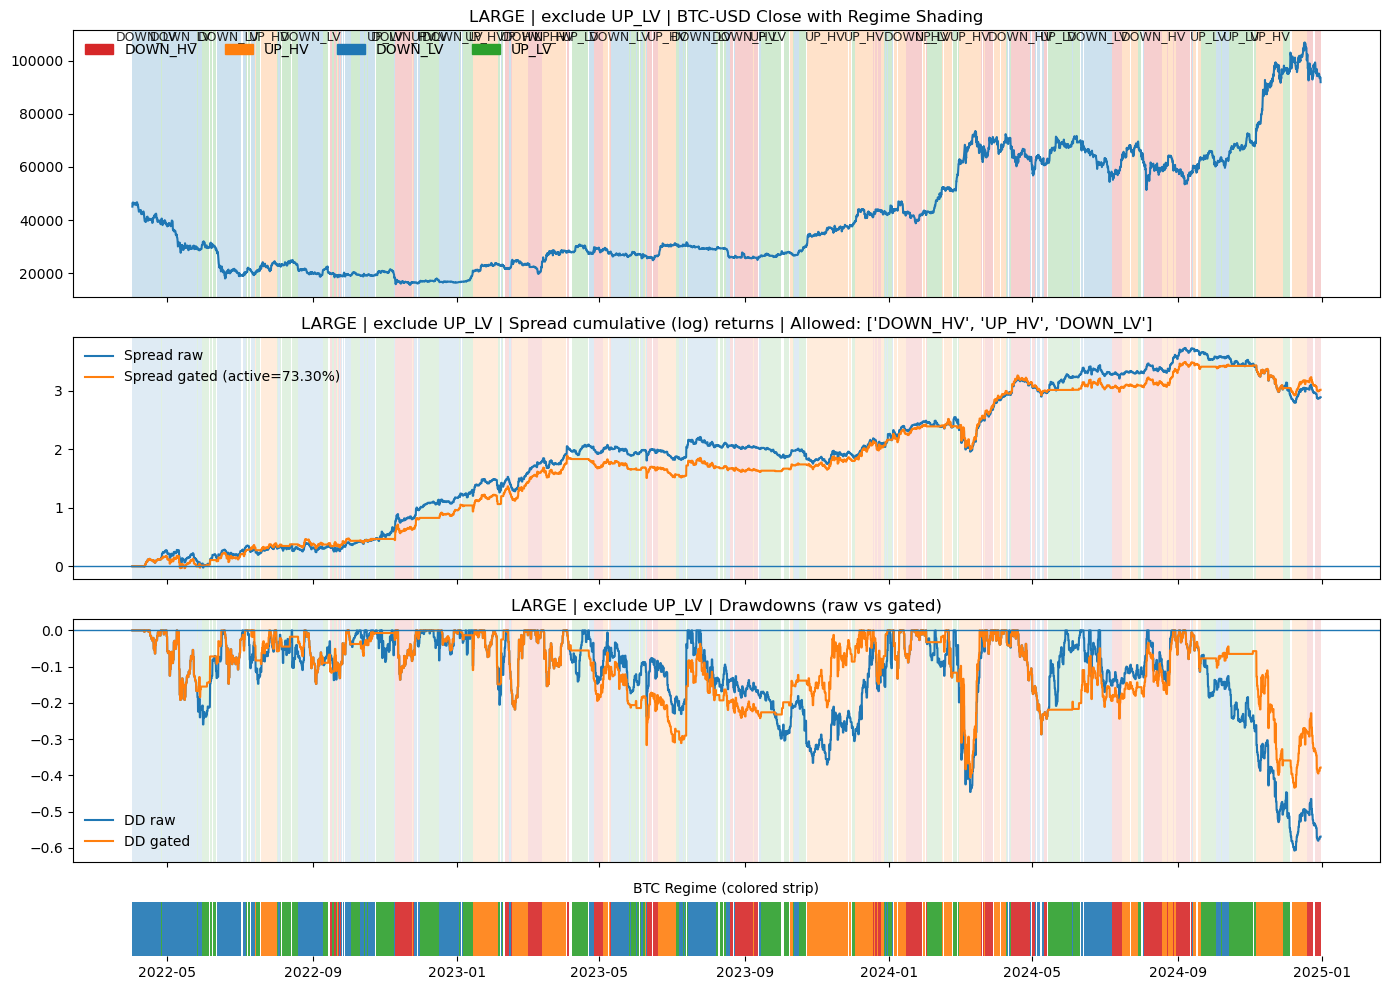

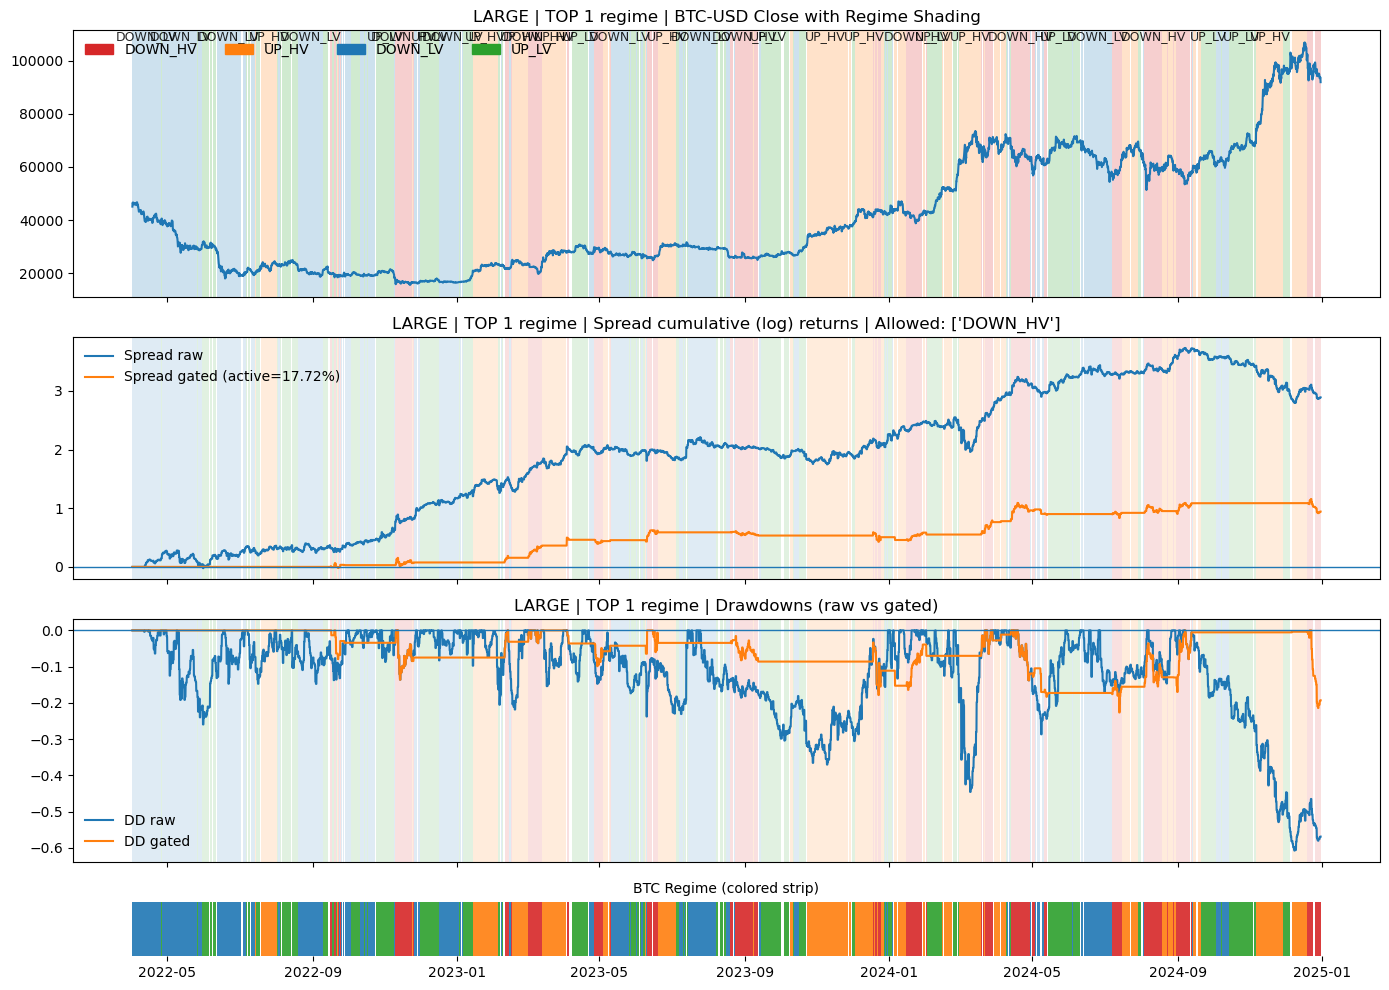

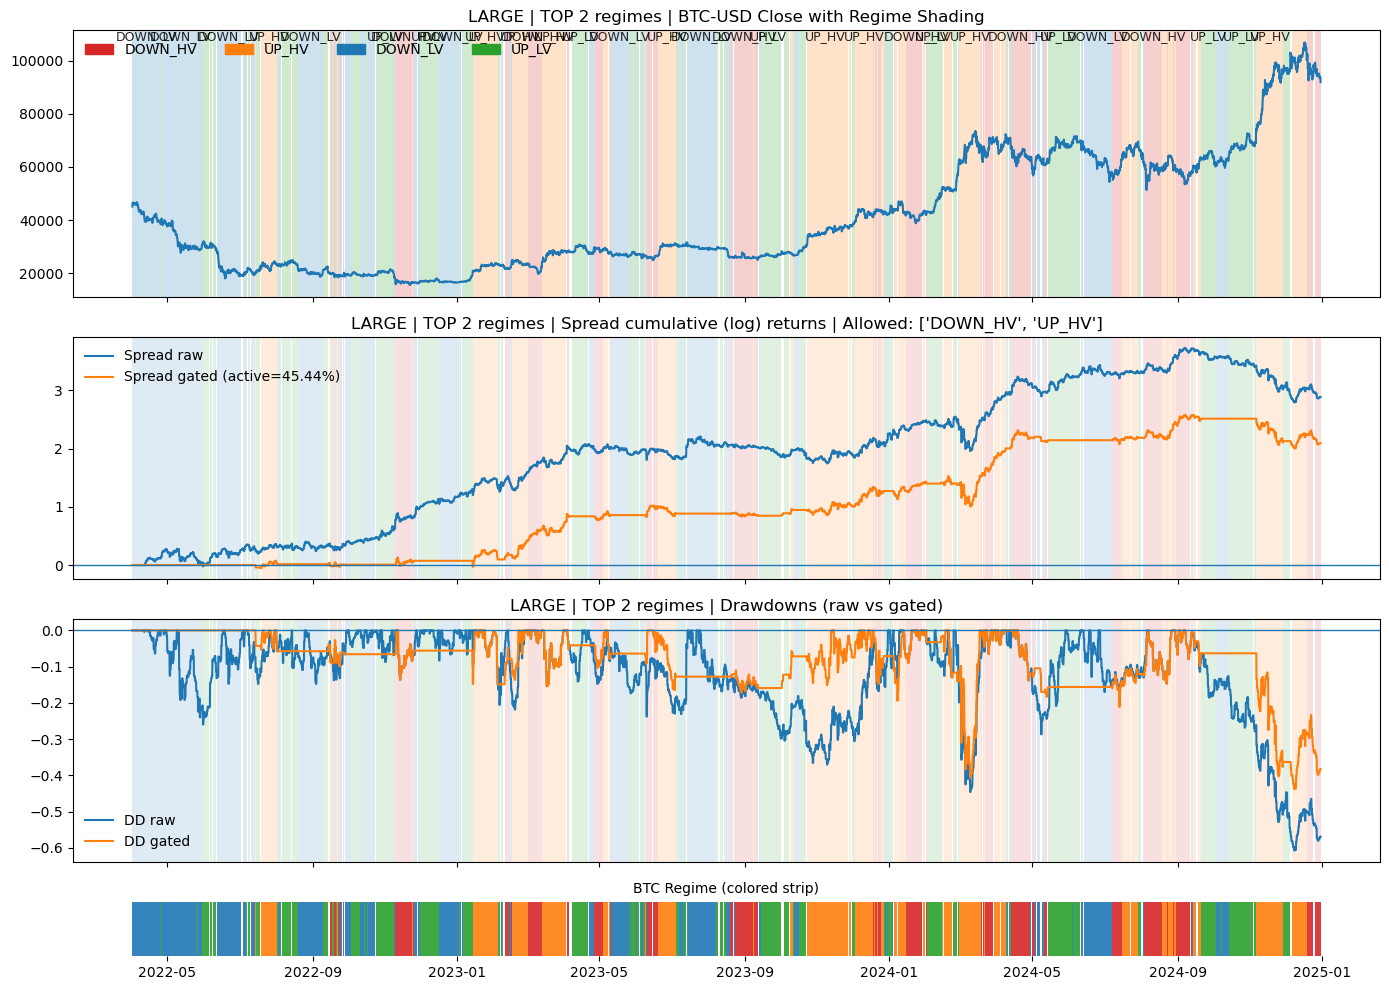

In [279]:
summary_large, allowed_sets = run_large_regime_experiments(
    df_diag=df_diag,
    btc_reg=btc_reg,
    spread_large_df=spread_large,
    spread_ret_col="spread_d0_d9",   # change if your spread return column name differs
)



=== SMALL regime summary (ranked by Sharpe) ===
             mean       std     n  hit_rate  frac_time    sharpe
regime                                                          
DOWN_HV  0.002396  0.016332  1068  0.191948   0.177232  6.865590
UP_LV    0.001299  0.015894  1609  0.190180   0.267010  3.823415
DOWN_LV  0.001014  0.018457  1679  0.178678   0.278626  2.570763
UP_HV    0.001084  0.020738  1670  0.188623   0.277132  2.445327

SMALL allowed sets:
Exclude UP_LV: ['DOWN_HV', 'UP_HV', 'DOWN_LV']
Top 1: ['DOWN_HV']
Top 2: ['DOWN_HV', 'UP_LV']


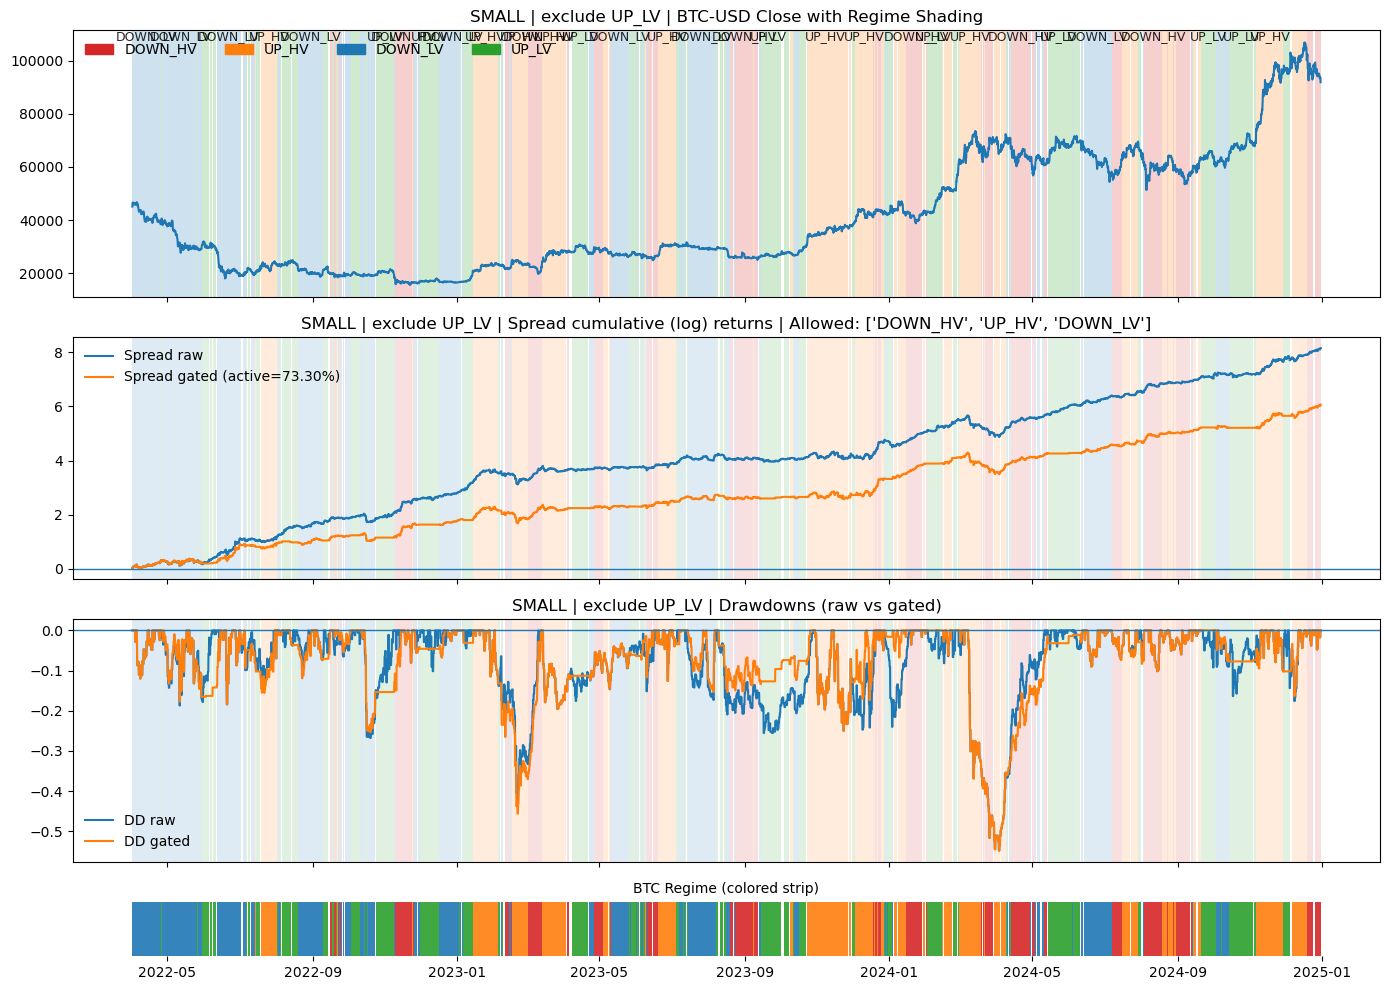

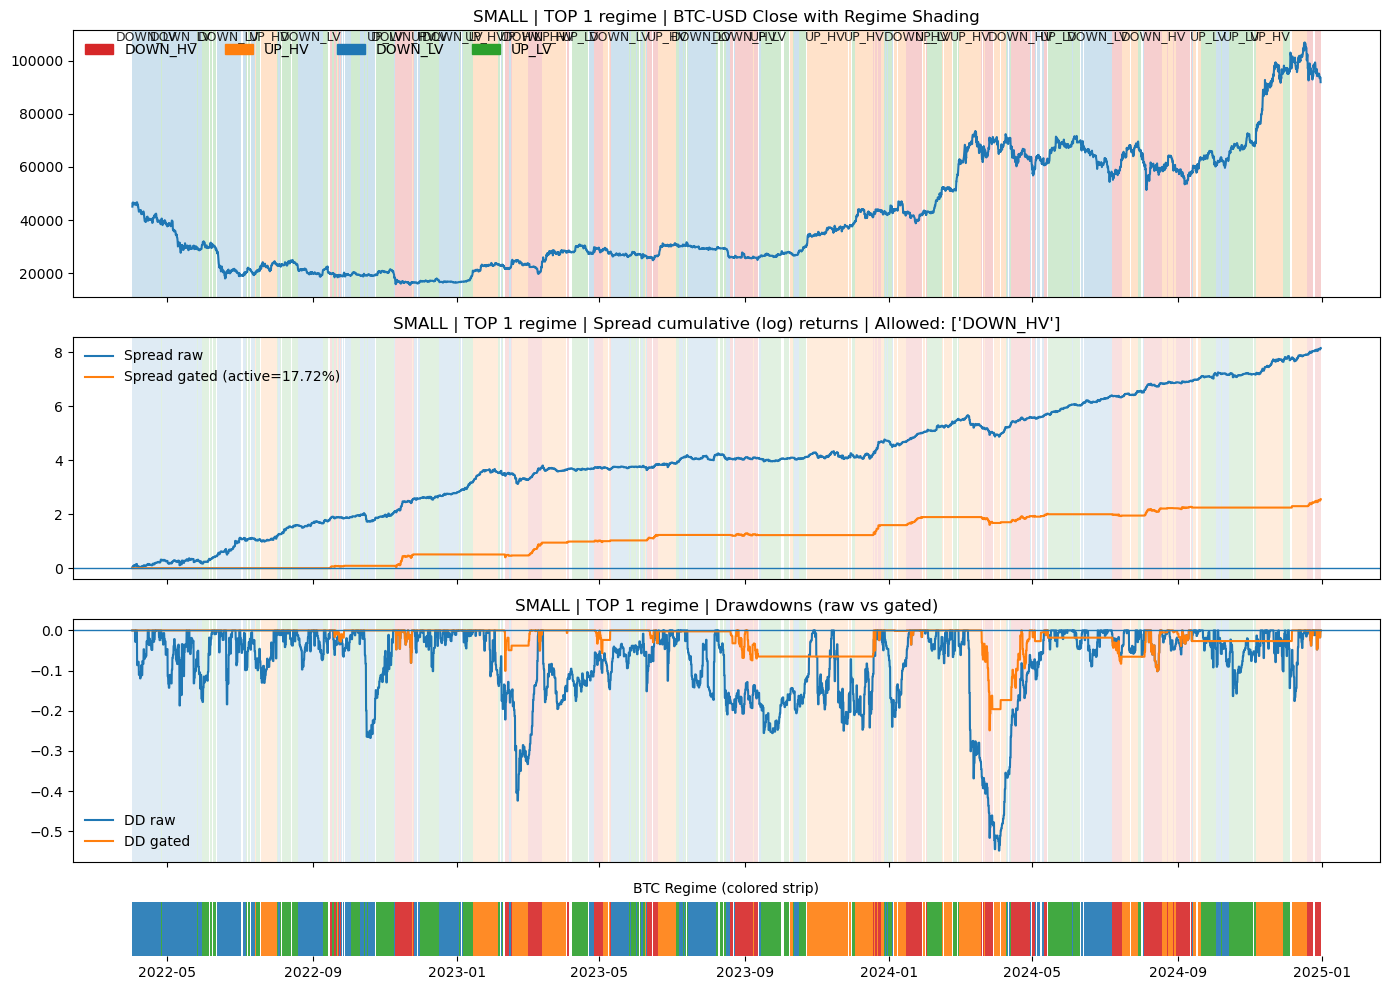

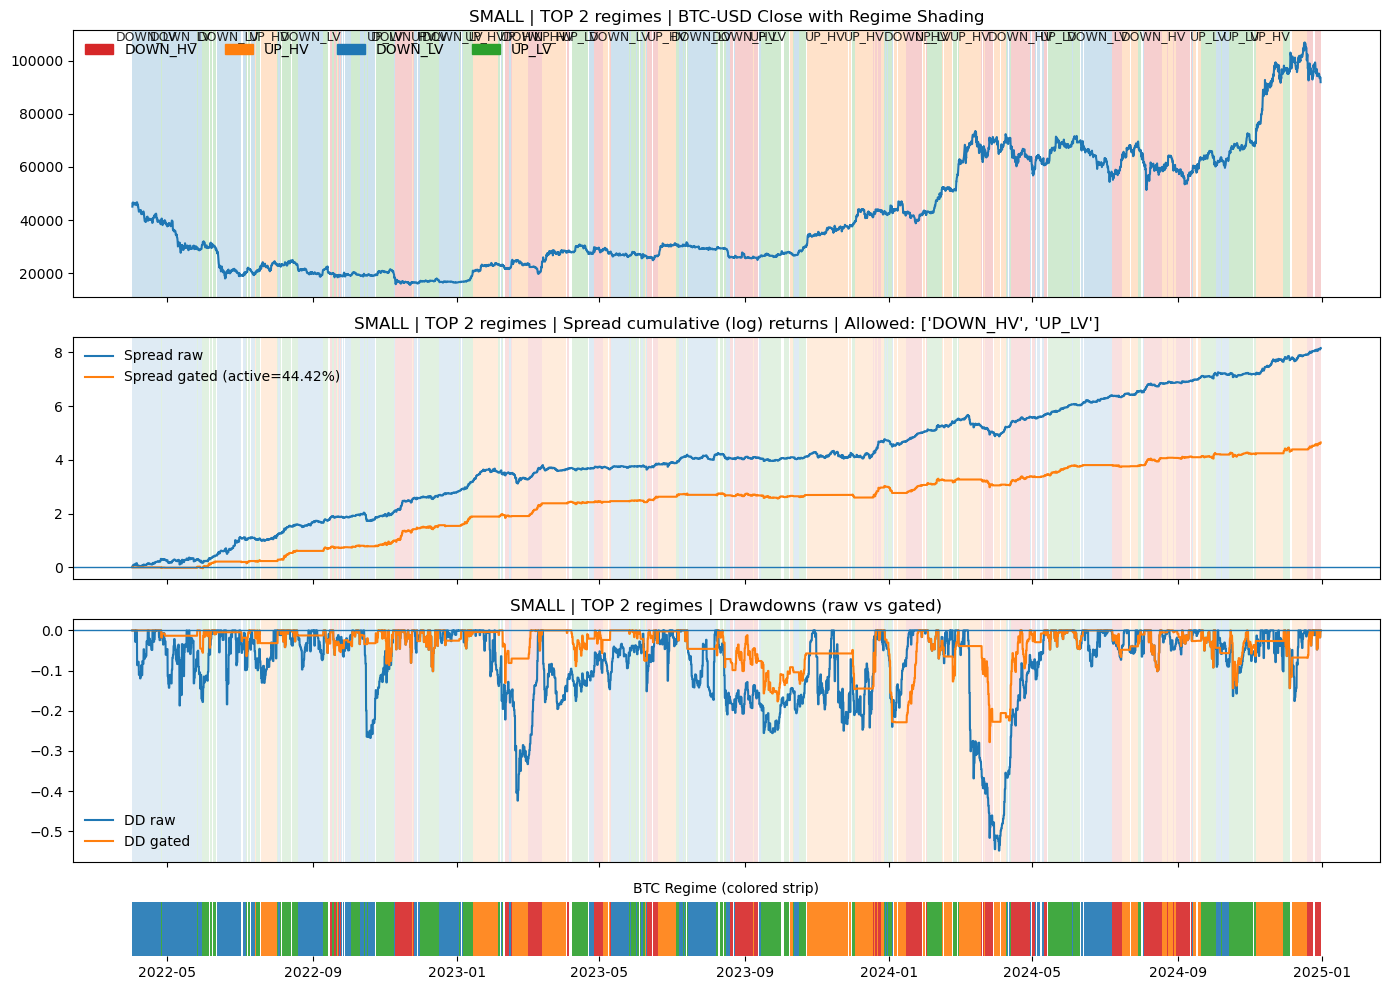

In [281]:
summary_small, allowed_sets = run_large_regime_experiments(
    df_diag=df_diag,
    btc_reg=btc_reg,
    spread_large_df=spread_small,
    spread_ret_col="spread_d0_d9",   # change if your spread return column name differs
    cohort='SMALL'
)